In [1]:
from sqlite3 import SQLITE_CREATE_VIEW
import anndata
import scanpy as sc
import os
#from bbknn import bbknn
import matplotlib.pyplot as plt
import omicverse as ov
#import scib
from scvi.model.utils import mde
#from scib_metrics.benchmark import Benchmarker
import scvi
#import scanorama
import numpy as np
#import pyliger
#from harmony import harmonize
from rich import print
import seaborn as sns
#import bbknn
#import doubletdetection
%matplotlib inline
import pandas as pd
plt.rcParams.update({'font.size': 12})


   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

Version: 1.5.3, Tutorials: https://omicverse.readthedocs.io/


[rank: 0] Global seed set to 0


In [2]:
plt.rcParams['pdf.fonttype'] = 42  # Ensures that fonts are saved as text, not outlines
#plt.rcParams['font.sans-serif'] = ['Arial']  # Use Arial or another common font

In [3]:
#####Change path and Load data
os.chdir("/storage/liuxiaodongLab/fanxueying/mayanalysis/2024Aug")
adata = anndata.read_h5ad("monkey_reanno.h5ad")
#adata = anndata.read_h5ad("monkey_reanno_clean.h5ad")

In [4]:
adata

AnnData object with n_obs × n_vars = 142676 × 44223
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'stage', 'percent.mt', 'species', 'embryo', 'platform', 'ann_level_2', 'ann_level_3', 'ann_level_1', 'doublet', 'doublet_score', 'Unintegrated_res_0.5', 'Scanorama_res_0.5', 'LIGER_res_0.5', 'Harmony_res_0.5', 'scVI_res_0.5', 'scANVI_res_0.5', 'CCA_res_0.5', 'FastMNN_res_0.5', 'leiden_1', 'leiden_2', 'leiden_3', 'leiden_4', 'reanno'
    var: 'features', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'CCA_res_0.5_colors', 'FastMNN_res_0.5_colors', 'Harmony_res_0.5_colors', 'LIGER_res_0.5_colors', 'Scanorama_res_0.5_colors', 'Unintegrated_res_0.5_colors', 'anno_colors', 'harmo.anno_colors', 'hvg', 'leiden', 'leiden_3_colors', 'log1p', 'neighbors', 'orig.ident_colors', 'pca', 'reanno_colors', 'scANVI_res_0.5_colors', 'scVI_res_0.5_colors', 'stage_colors', 'sub_anno_colors', 'umap'
 

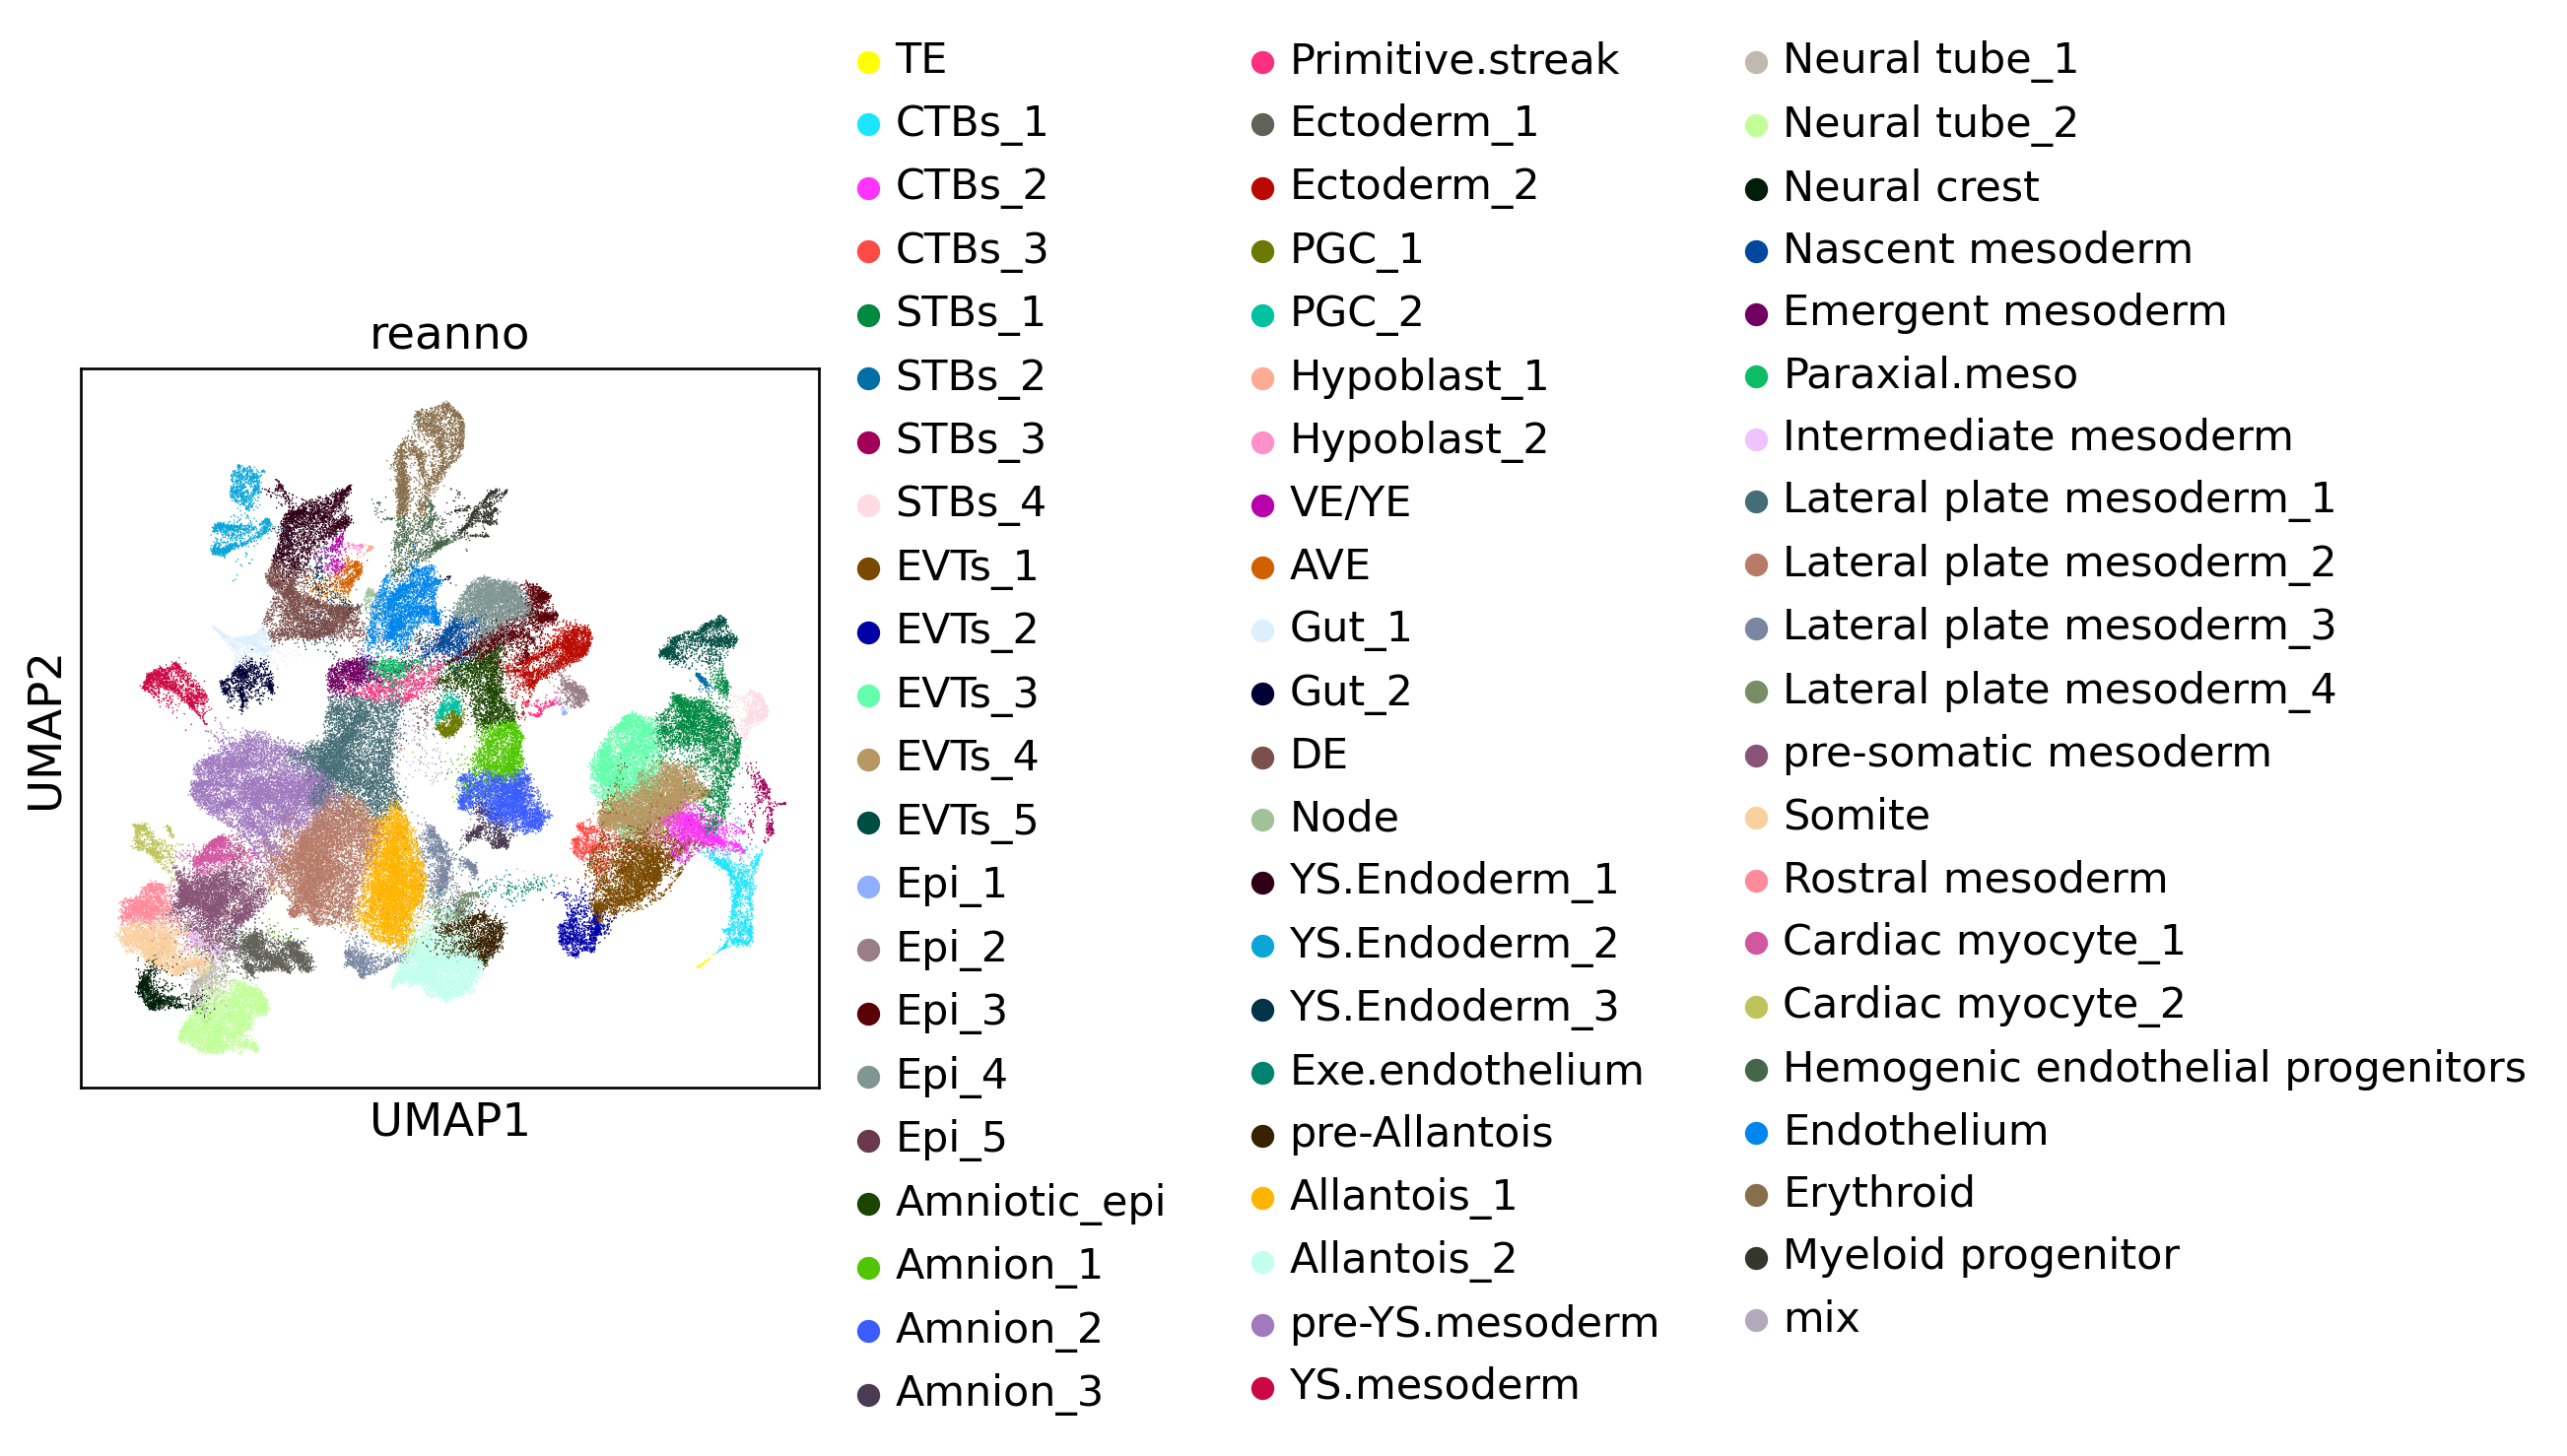

In [5]:
sc.pl.umap(adata, color=['reanno'])

In [6]:
set(adata.obs['stage'] )

{'CS11',
 'CS8',
 'CS9',
 'E10_IVC',
 'E11_IVC',
 'E12_IVC',
 'E13',
 'E13_IVC',
 'E14',
 'E14_IVC',
 'E15_IVC',
 'E16',
 'E16_IVC',
 'E17',
 'E17_IVC',
 'E18_IVC',
 'E19_IVC',
 'E20_IVC',
 'E21_IVC',
 'E22_IVC',
 'E23_IVC',
 'E24_IVC',
 'E25_IVC',
 'E6',
 'E7',
 'E8',
 'E9',
 'E9_IVC'}

In [7]:
# Define the desired order of the stages
stage_order = ['E6', 'E7', 'E8', 'E9', 'E9_IVC', 'E10_IVC', 'E11_IVC', 'E12_IVC', 
    'E13', 'E13_IVC', 'E14', 'E14_IVC', 'E15_IVC', 'E16', 'E16_IVC',
    'E17', 'E17_IVC', 'E18_IVC', 'E19_IVC', 'E20_IVC', 'E21_IVC', 
    'E22_IVC', 'CS8', 'E23_IVC', 'E24_IVC', 'E25_IVC', 'CS9', 'CS11']

# Convert the 'stage' column to a categorical type with the specified order
adata.obs['stage'] = pd.Categorical(adata.obs['stage'], categories=stage_order, ordered=True)

In [8]:
#define lineages
# Define lineages
lineages = {
    'TE_TrB': [ 'TE', 'CTBs_1','CTBs_2','CTBs_3','STBs_1','STBs_2','STBs_3', 'STBs_4', 'STBs_5', 
                      'EVTs_1', 'EVTs_2', 'EVTs_3', 'EVTs_4','EVTs_5', ],
    'epi': [ 'Epi_1','Epi_2','Epi_3','Epi_4','Epi_5','Epi_6',],
    'Gastru': ['Primitive.streak', 'Nascent mesoderm','Gastru.Endoderm'],
    'Notochord': ['Node',],
    'PGC': ['PGC_1','PGC_2',],
    'ExE_endo': ['Hypoblast_1','Hypoblast_2','VE/YE','AVE','YS.Endoderm_1','YS.Endoderm_2','YS.Endoderm_3', ],
    'Exe_meso': [ 'pre-Allantois', 'Allantois_1','Allantois_2', 'pre-YS.mesoderm','YS.mesoderm', 'Exe.endothelium', 'Amniotic mesoderm',],
    'non_neuro_ecto': [ 'Amniotic_epi','Amnion_1','Amnion_2','Amnion_3','Epithelium','Ectoderm_1','Ectoderm_2',],
    'neural_ecto': [ 'Neural tube_1','Neural tube_2','Neural crest',],
    'Endoderm': ['Gut_1','Gut_2', 'DE', ],
    'mesoderm': [ 'Emergent mesoderm', 'Paraxial.meso','Intermediate mesoderm', 'Lateral plate mesoderm_1',
     'Lateral plate mesoderm_2','Lateral plate mesoderm_3','Lateral plate mesoderm_4',
     'pre-somatic mesoderm','Somite','Rostral mesoderm',
     'Cardiac myocyte_1','Cardiac myocyte_2', ],
    'hemogenic': [   'Hemogenic endothelial progenitors', 'Endothelium','Erythroid','Myeloid progenitor',],

   
}

# Create a new column 'lineage' with default values
adata.obs['lineage'] = 'Unknown'

# Loop through each lineage and assign the corresponding cells
for lineage, annotations in lineages.items():
    adata.obs.loc[adata.obs['reanno'].isin(annotations), 'lineage'] = lineage

# Save the updated AnnData object if needed
# adata.write('path_to_save/adata_with_lineage.h5ad')

# Verify the changes
adata.obs['lineage'].value_counts()


mesoderm          33830
TE_TrB            30114
Exe_meso          25281
non_neuro_ecto    14987
hemogenic          8948
epi                6991
neural_ecto        6866
ExE_endo           6053
Endoderm           5834
Gastru             2186
PGC                1051
Notochord           391
Unknown             144
Name: lineage, dtype: int64

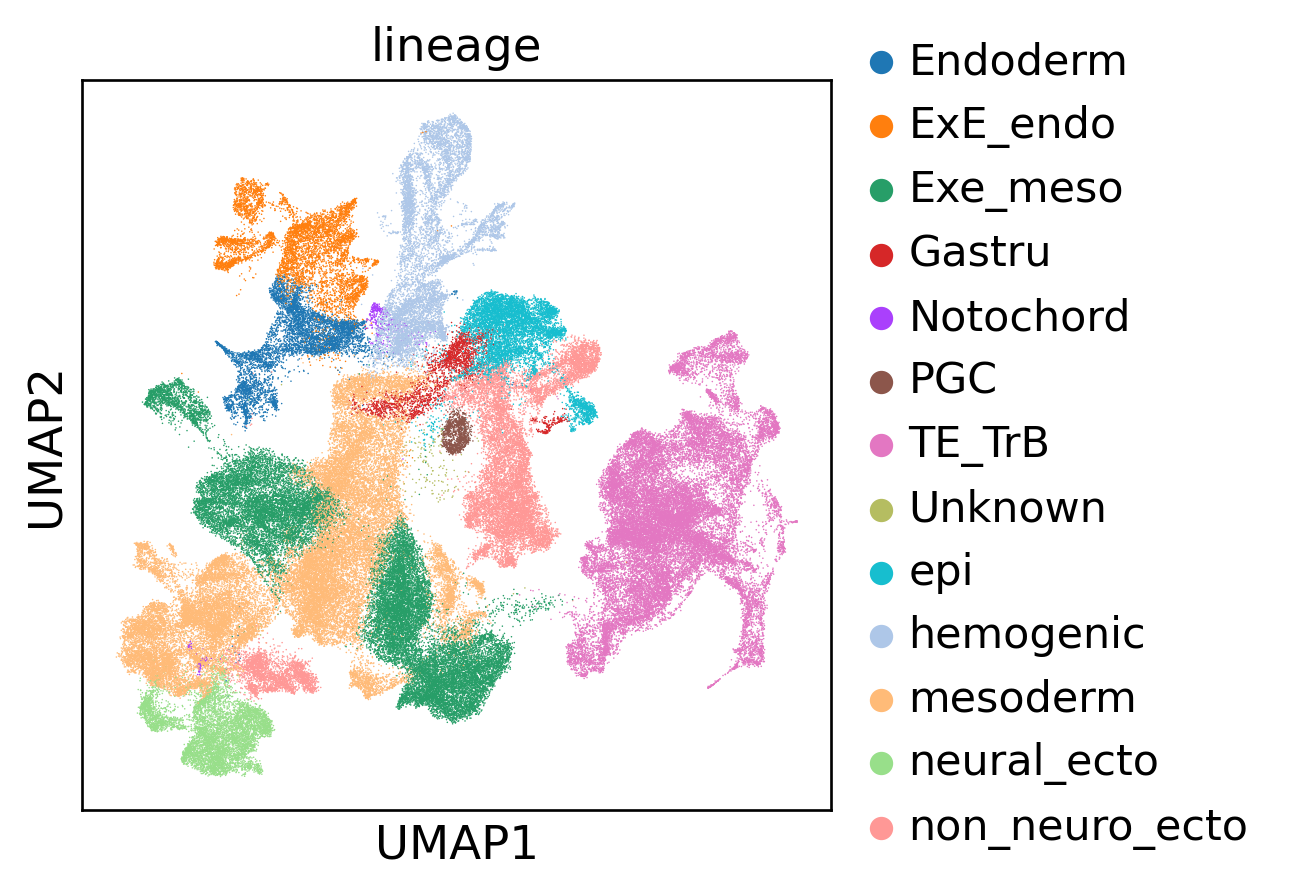

In [9]:
sc.pl.umap(adata, color=['lineage'])

In [10]:
#remove mix/unknown cells
adata = adata[adata.obs['reanno'] != 'mix'].copy()

In [11]:
adata

AnnData object with n_obs × n_vars = 142532 × 44223
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'stage', 'percent.mt', 'species', 'embryo', 'platform', 'ann_level_2', 'ann_level_3', 'ann_level_1', 'doublet', 'doublet_score', 'Unintegrated_res_0.5', 'Scanorama_res_0.5', 'LIGER_res_0.5', 'Harmony_res_0.5', 'scVI_res_0.5', 'scANVI_res_0.5', 'CCA_res_0.5', 'FastMNN_res_0.5', 'leiden_1', 'leiden_2', 'leiden_3', 'leiden_4', 'reanno', 'lineage'
    var: 'features', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'CCA_res_0.5_colors', 'FastMNN_res_0.5_colors', 'Harmony_res_0.5_colors', 'LIGER_res_0.5_colors', 'Scanorama_res_0.5_colors', 'Unintegrated_res_0.5_colors', 'anno_colors', 'harmo.anno_colors', 'hvg', 'leiden', 'leiden_3_colors', 'log1p', 'neighbors', 'orig.ident_colors', 'pca', 'scANVI_res_0.5_colors', 'scVI_res_0.5_colors', 'stage_colors', 'sub_anno_colors', 'umap', 'linea

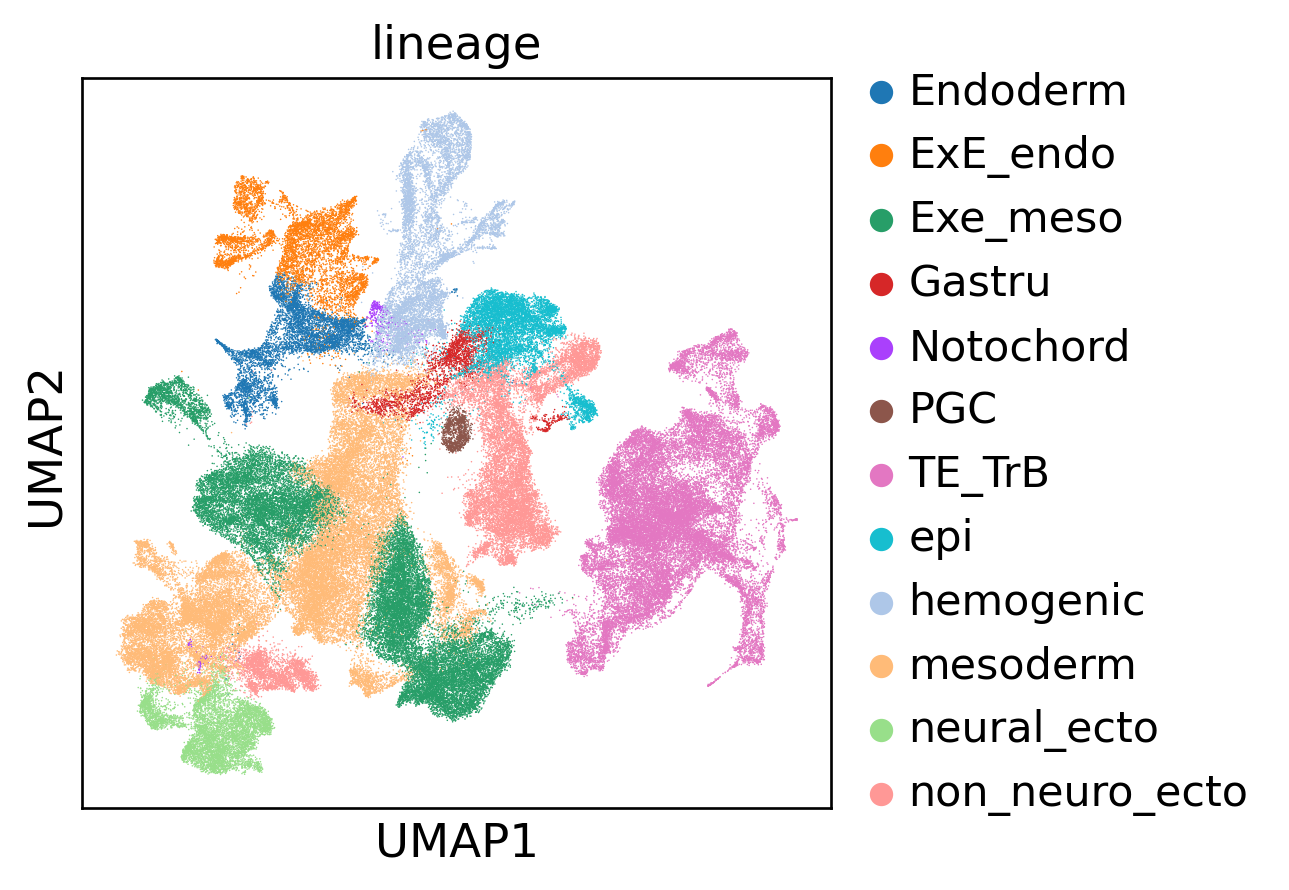

In [12]:
sc.pl.umap(adata, color=['lineage'])

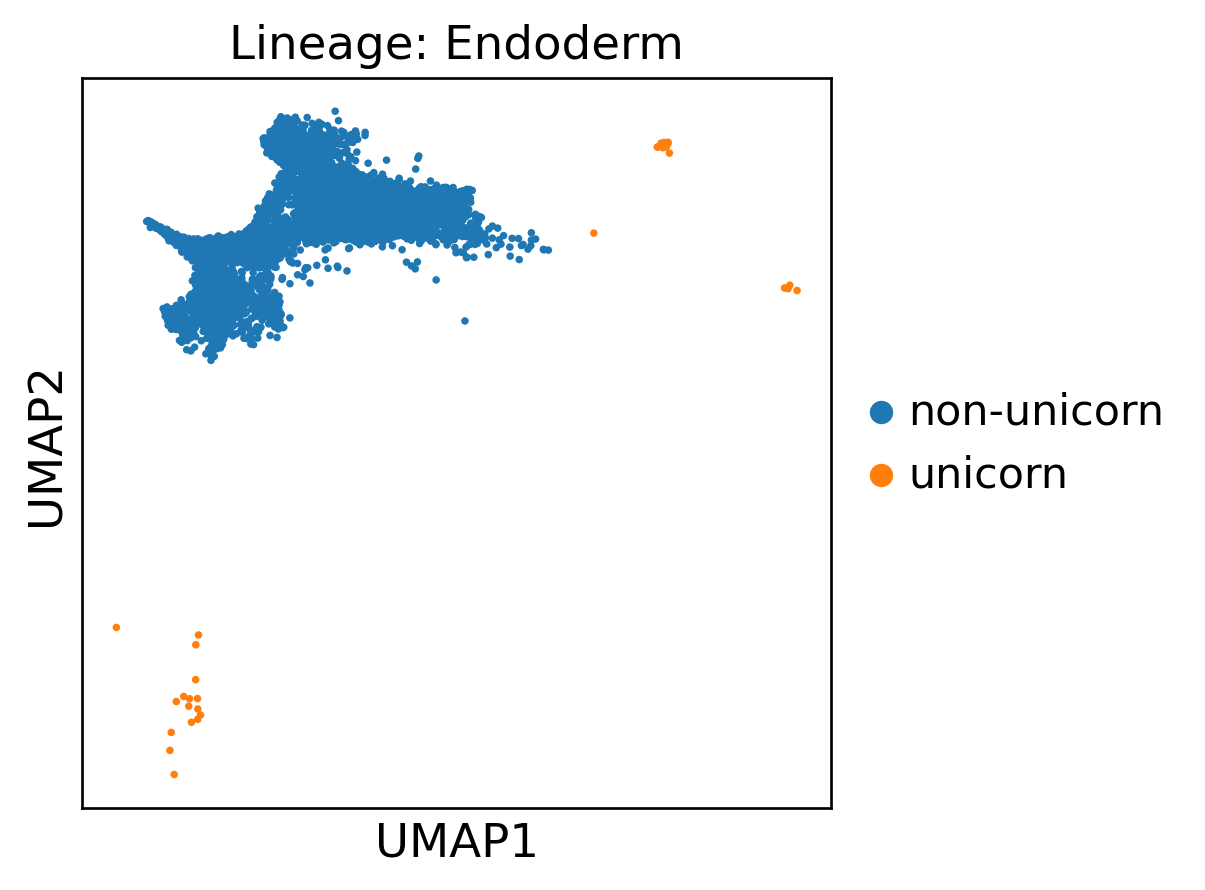

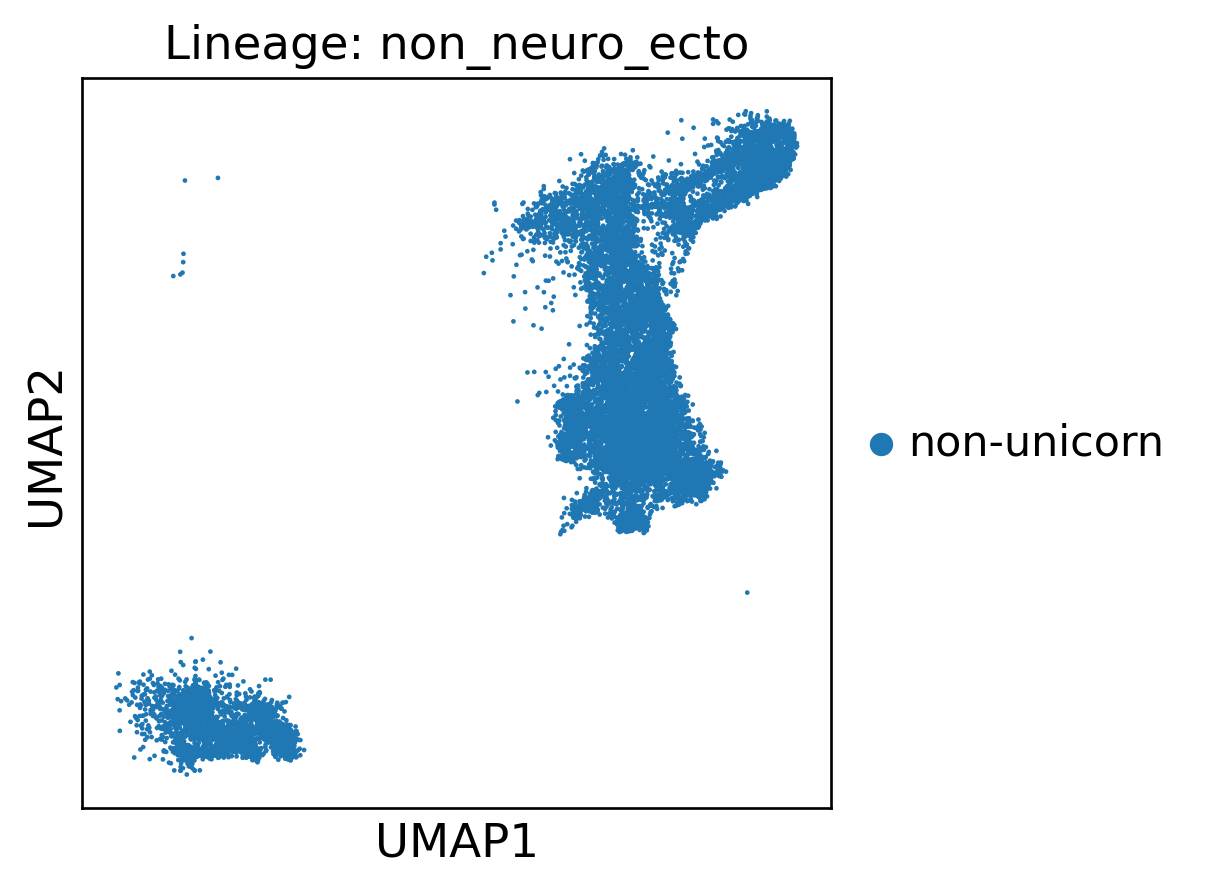

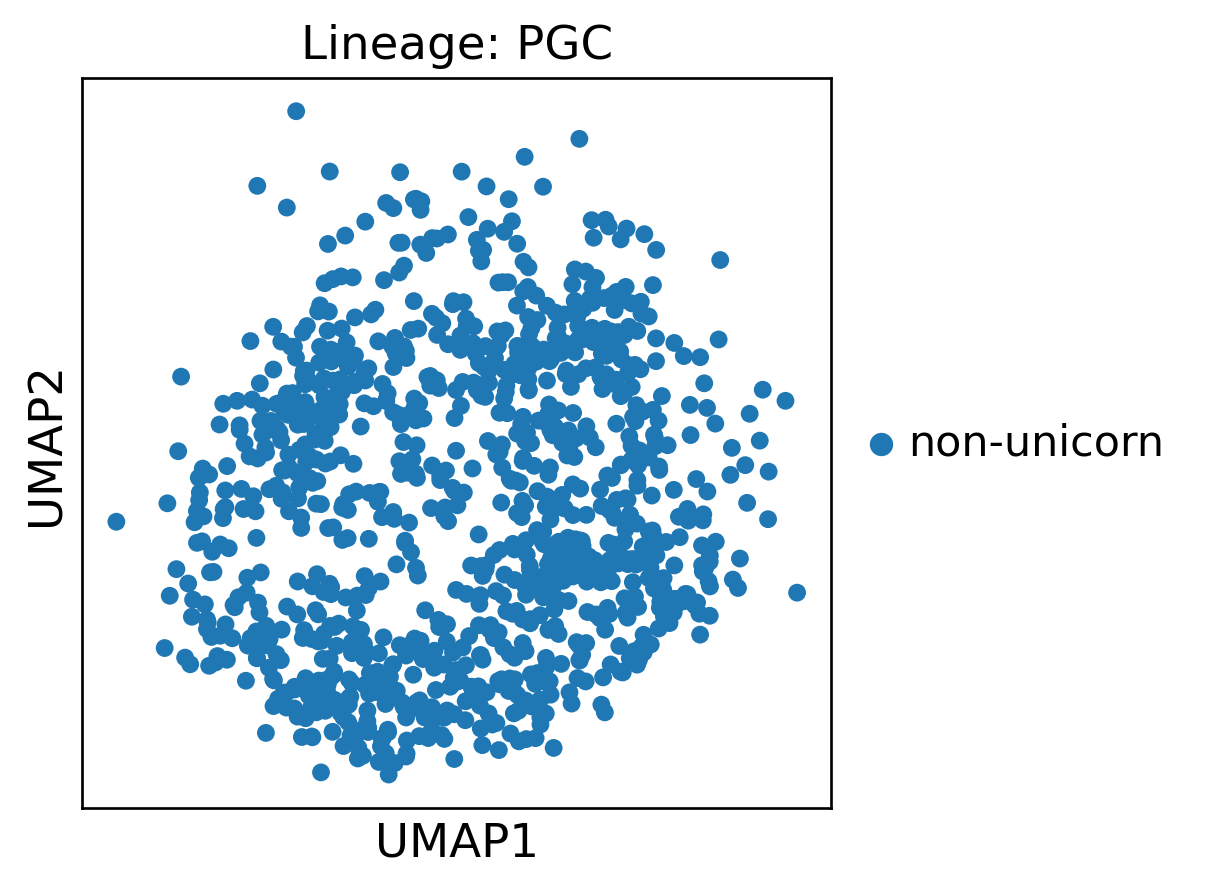

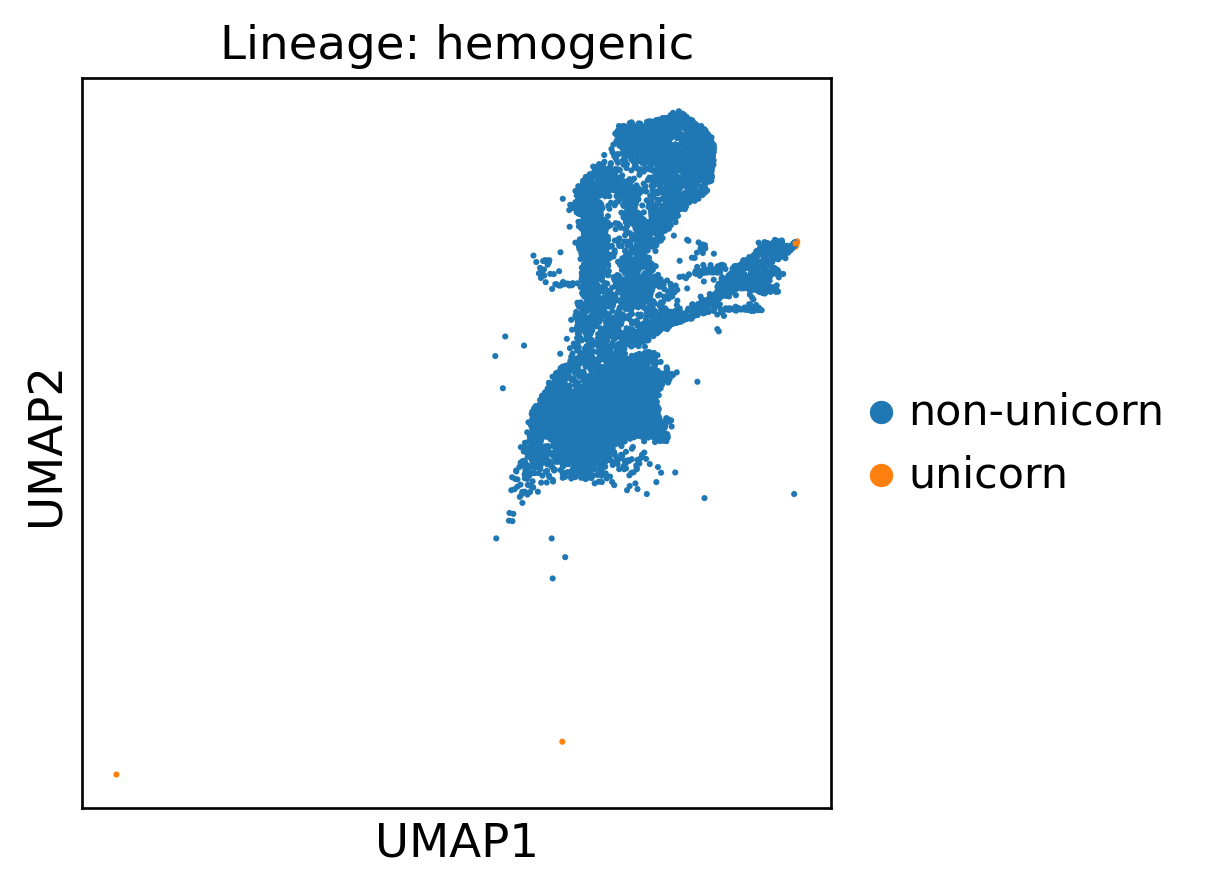

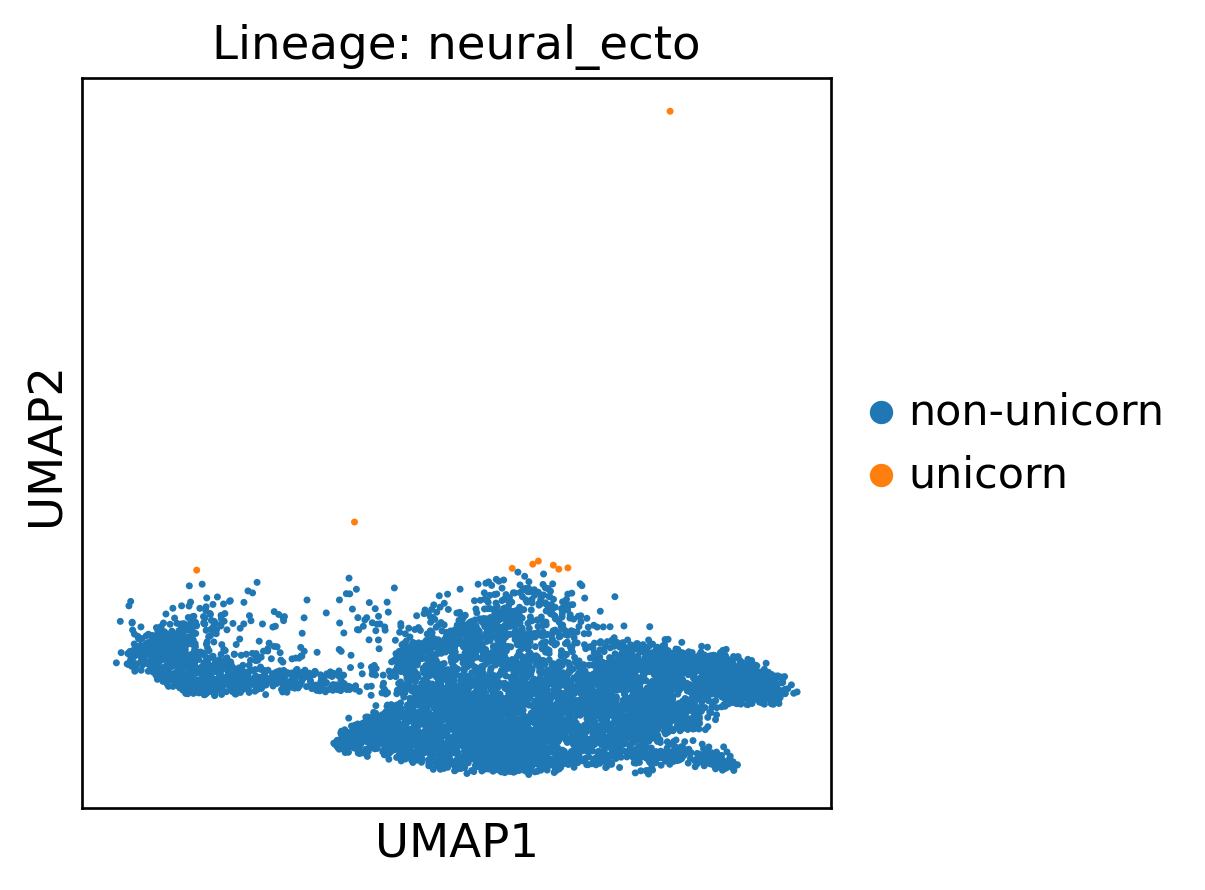

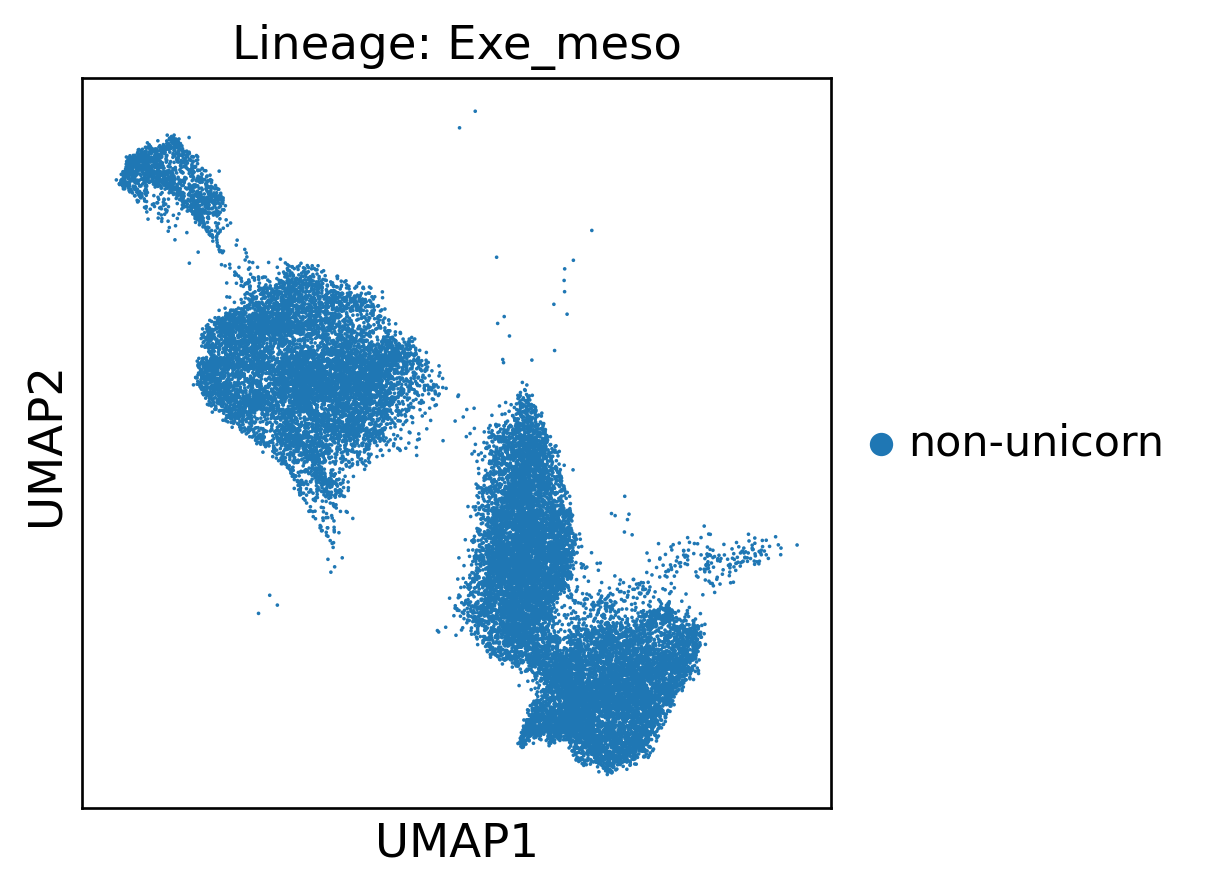

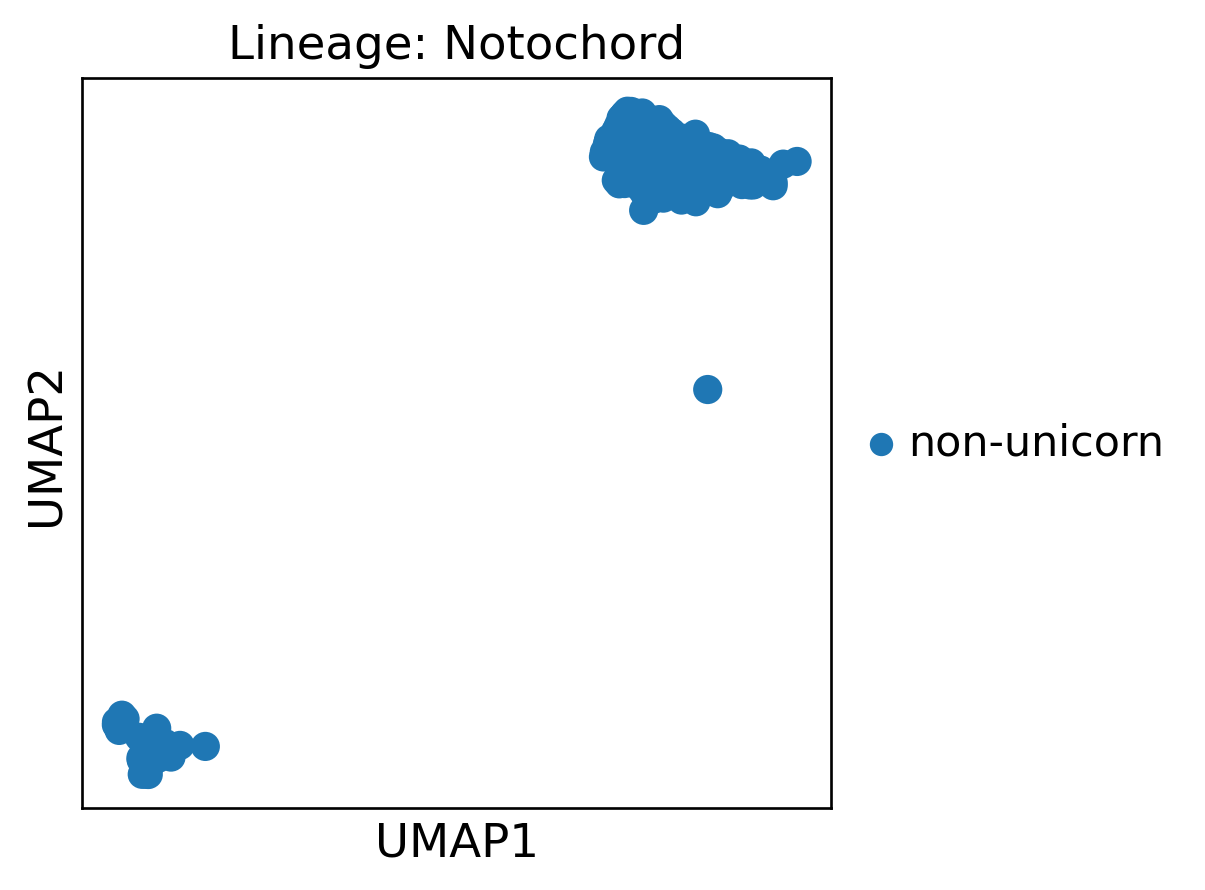

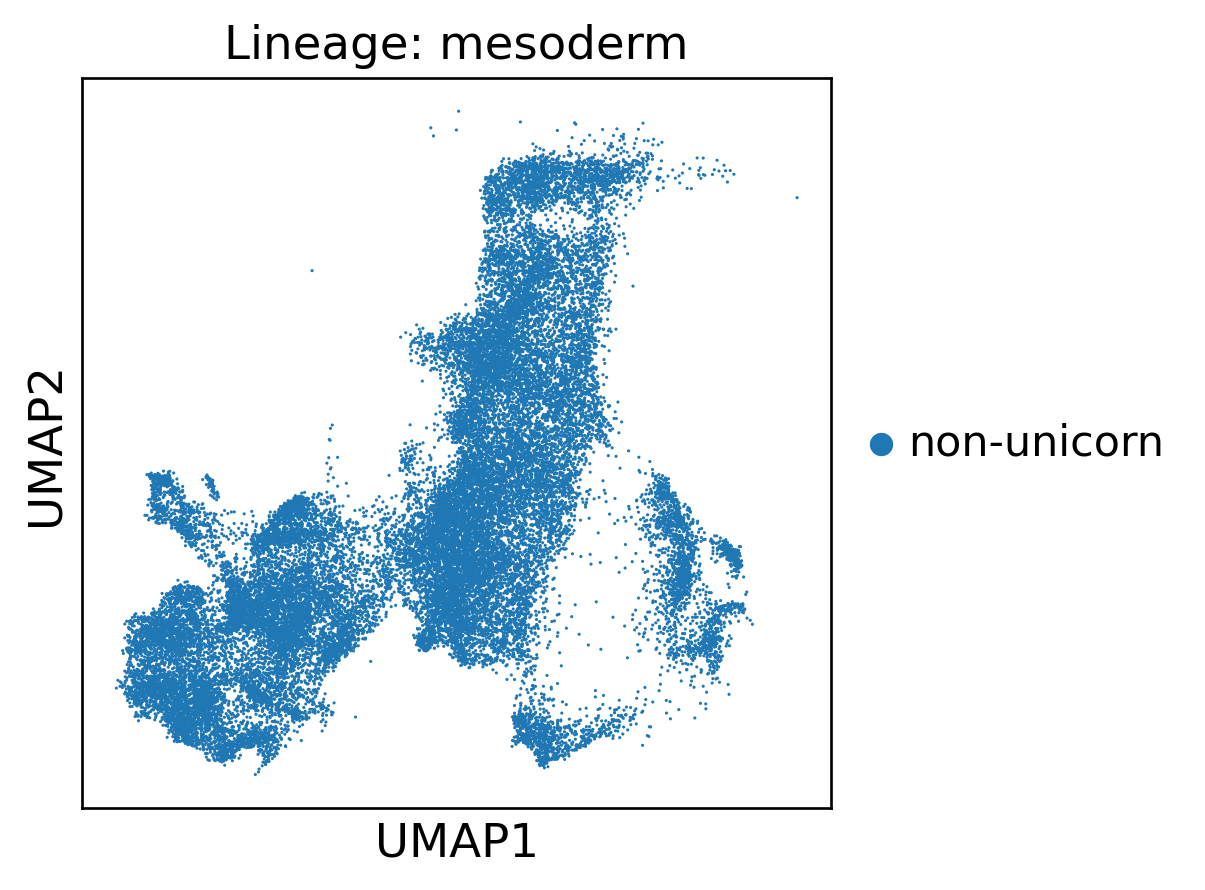

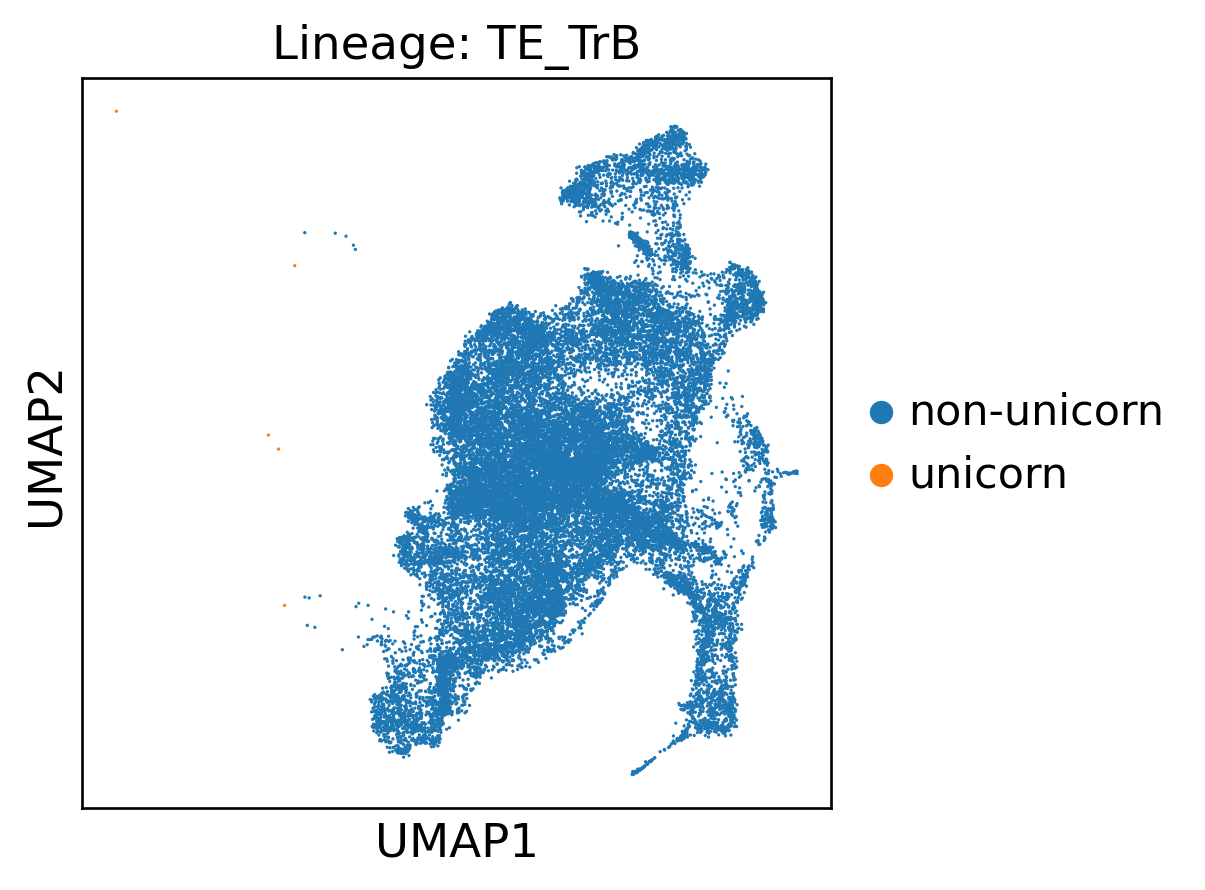

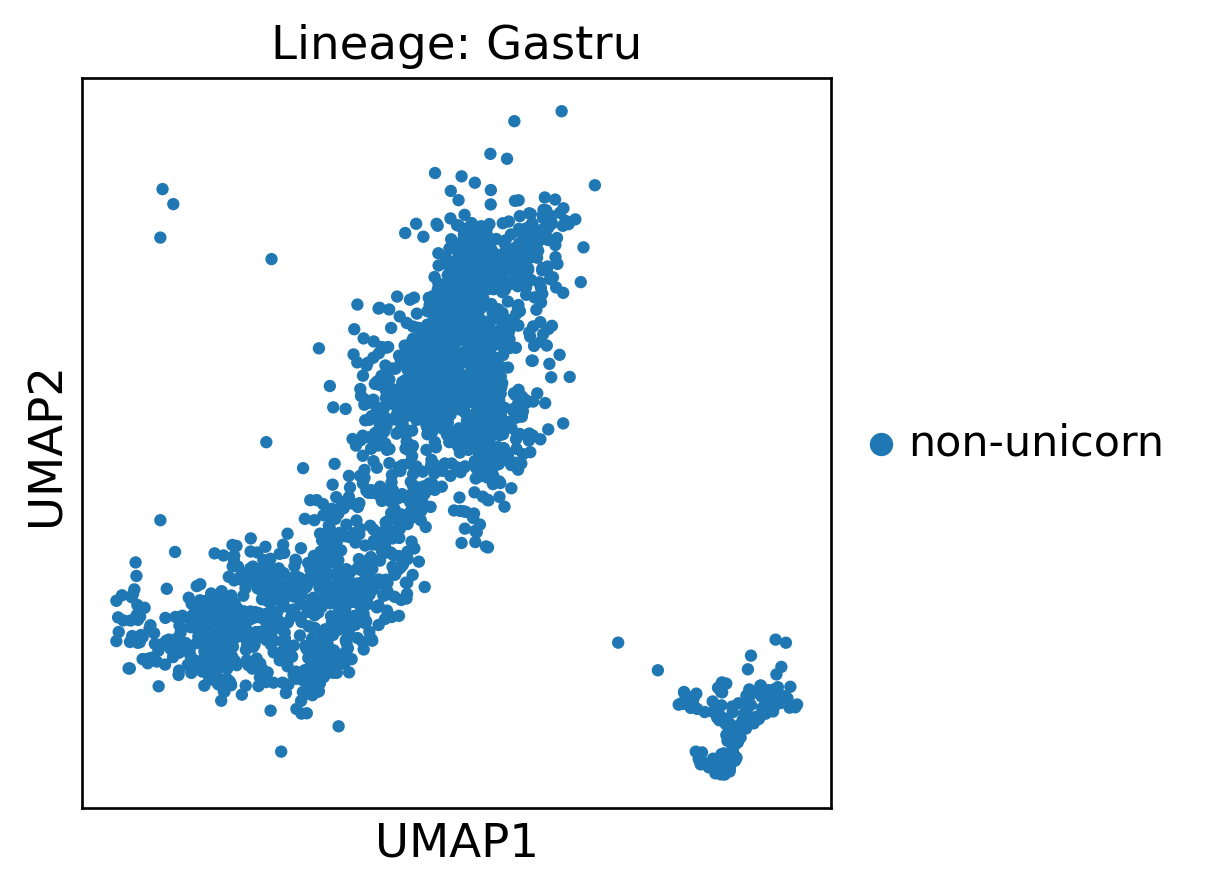

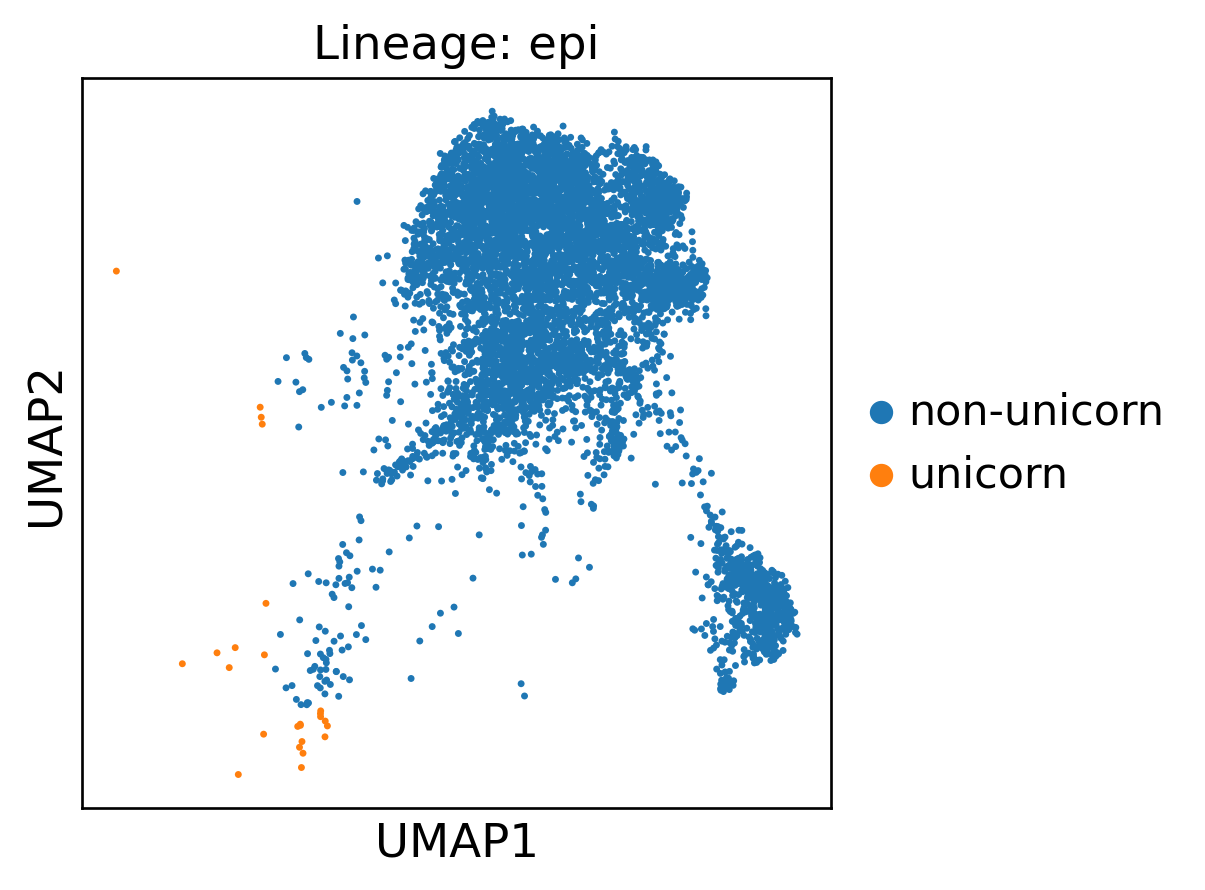

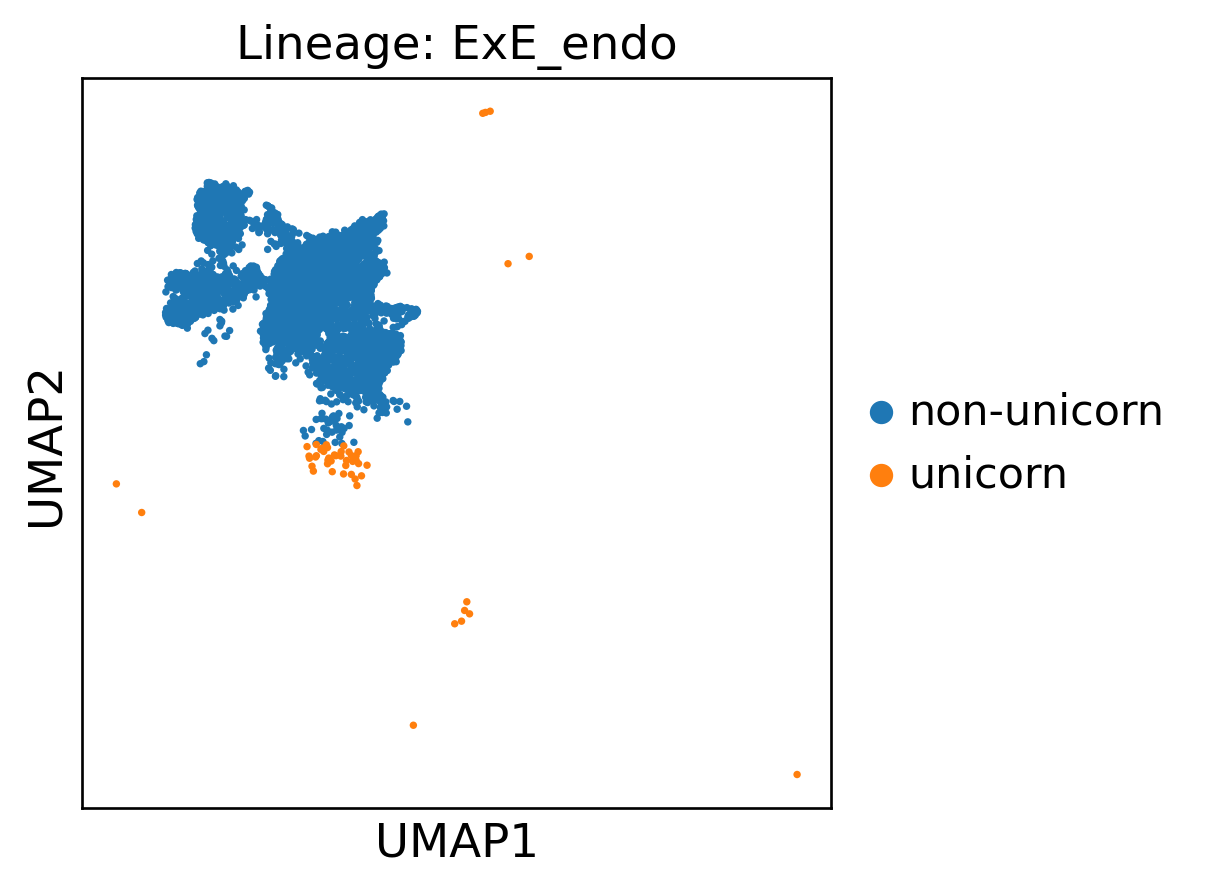

In [13]:
#identify unicorns which are located far away from the main population
from scipy.stats import zscore

# List of lineages to process
lineages = set(adata.obs.lineage)

# Initialize the 'unicorns' column in the main adata if it doesn't exist
if 'unicorns' not in adata.obs.columns:
    adata.obs['unicorns'] = 'non-unicorn'

# Threshold for identifying outliers
threshold = 3

# Loop through each lineage
for lineage in lineages:
    # Subset the data based on the current lineage
    ana_sub = adata[adata.obs['lineage'].isin([lineage])]
    
    # Get the UMAP coordinates
    umap_coords = ana_sub.obsm['X_umap']
    
    # Calculate z-scores for the UMAP coordinates
    z_scores_umap = np.abs(zscore(umap_coords, axis=0))
    
    # Create a boolean mask for outliers based on the threshold in both UMAP1 and UMAP2
    outlier_condition = (z_scores_umap[:, 0] > threshold) | (z_scores_umap[:, 1] > threshold)
    
    # Initialize all as 'non-unicorn'
    ana_sub.obs['unicorns'] = 'non-unicorn'
    
    # Update the 'unicorns' label for the outliers
    ana_sub.obs.loc[ana_sub.obs.index[outlier_condition], 'unicorns'] = 'unicorn'
    
    # Optional: Plot to verify for each lineage
    sc.pl.umap(ana_sub, color='unicorns', title=f'Lineage: {lineage}')
    
    # Update the main adata object with the 'unicorns' label from ana_sub
    adata.obs.loc[ana_sub.obs.index, 'unicorns'] = ana_sub.obs['unicorns']

# After the loop, the 'unicorns' labels in the main adata will be updated for the specified lineages.


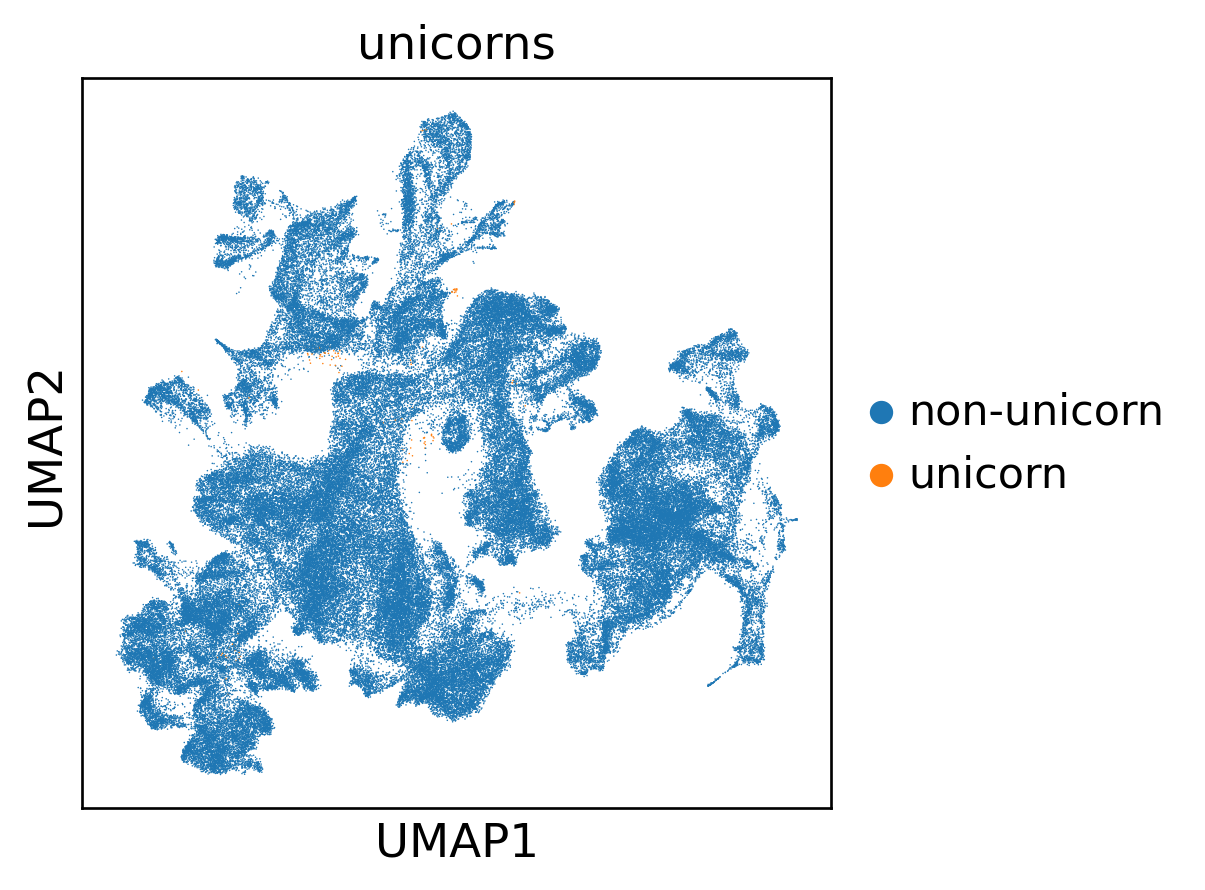

In [14]:
sc.pl.umap(adata, color=['unicorns'])

In [15]:
# remove cells with conflicting annotations
df_counts = pd.crosstab(adata.obs['reanno'], adata.obs['stage']).reset_index()
df_counts = pd.melt(df_counts, id_vars=['reanno'], var_name='stage', value_name='Freq')

# Filter to find rows where Freq <= 3
low_count_rows = df_counts[df_counts['Freq'] <= 4]

# Set display options to show all rows and columns
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns

# Print the DataFrame
print(low_count_rows)



reanno    stage  Freq
1                                CTBs_1       E6     0
2                                CTBs_2       E6     0
3                                CTBs_3       E6     0
4                                STBs_1       E6     0
5                                STBs_2       E6     0
6                                STBs_3       E6     0
7                                STBs_4       E6     0
8                                EVTs_1       E6     0
9                                EVTs_2       E6     0
10                               EVTs_3       E6     0
11                               EVTs_4       E6     0
12                               EVTs_5       E6     0
13                                Epi_1       E6     0
14                                Epi_2       E6     0
15                                Epi_3       E6     0
16                                Epi_4       E6     0
17                                Epi_5       E6     0
18                         Amniotic_epi       E6     0
19                             Amnion_1       E6     0
20                             Amnion_2       E6     0
21                             Amnion_3       E6     0
22                     Primitive.streak       E6     0
23                           Ectoderm_1       E6     0
24                           Ectoderm_2       E6     0
25                                PGC_1       E6     0
26                                PGC_2       E6     0
27                          Hypoblast_1       E6     0
28                          Hypoblast_2       E6     0
29                                VE/YE       E6     0
30                                  AVE       E6     0
31                                Gut_1       E6     0
32                                Gut_2       E6     0
33                                   DE       E6     0
34                                 Node       E6     0
35                        YS.Endoderm_1       E6     0
36                        YS.Endoderm_2       E6     0
37                        YS.Endoderm_3       E6     0
38                      Exe.endothelium       E6     0
39                        pre-Allantois       E6     0
40                          Allantois_1       E6     0
41                          Allantois_2       E6     0
42                      pre-YS.mesoderm       E6     0
43                          YS.mesoderm       E6     0
44                        Neural tube_1       E6     0
45                        Neural tube_2       E6     0
46                         Neural crest       E6     0
47                     Nascent mesoderm       E6     0
48                    Emergent mesoderm       E6     0
49                        Paraxial.meso       E6     0
50                Intermediate mesoderm       E6     0
51             Lateral plate mesoderm_1       E6     0
52             Lateral plate mesoderm_2       E6     0
53             Lateral plate mesoderm_3       E6     0
54             Lateral plate mesoderm_4       E6     0
55                 pre-somatic mesoderm       E6     0
56                               Somite       E6     0
57                     Rostral mesoderm       E6     0
58                    Cardiac myocyte_1       E6     0
59                    Cardiac myocyte_2       E6     0
60    Hemogenic endothelial progenitors       E6     0
61                          Endothelium       E6     0
62                            Erythroid       E6     0
63                   Myeloid progenitor       E6     0
66                               CTBs_2       E7     0
67                               CTBs_3       E7     0
68                               STBs_1       E7     0
69                               STBs_2       E7     0
70                               STBs_3       E7     0
71                               STBs_4       E7     0
72                               EVTs_1       E7     0
73                               EVTs_2       E7     0
74                               EVTs_3       E7     0
75                

In [16]:
# Combine 'reanno' and 'stage' into a single annotation for filtering
adata.obs['combined_annotation'] = adata.obs['reanno'].astype(str) + "_" + adata.obs['stage'].astype(str)

# Create a list of combined annotations to remove
annotations_to_remove = low_count_rows.apply(lambda row: f"{row['reanno']}_{row['stage']}", axis=1).tolist()

# Identify cells that match the annotations to remove
cells_to_remove = adata.obs['combined_annotation'].isin(annotations_to_remove)


# Update 'unicorns' column: if a cell matches the annotations to remove, set it to 'unicorns'
# Keep existing 'unicorns' labels and only add new ones
adata.obs.loc[cells_to_remove, 'unicorns'] = 'unicorn'

# Optional: You can ensure that cells not in the annotations_to_remove list keep their previous labels
# Uncomment the following line if you want to ensure 'unicorns' label is kept only for relevant cells
# adata.obs.loc[~cells_to_remove, 'unicorns'] = adata.obs.loc[~cells_to_remove, 'unicorns']


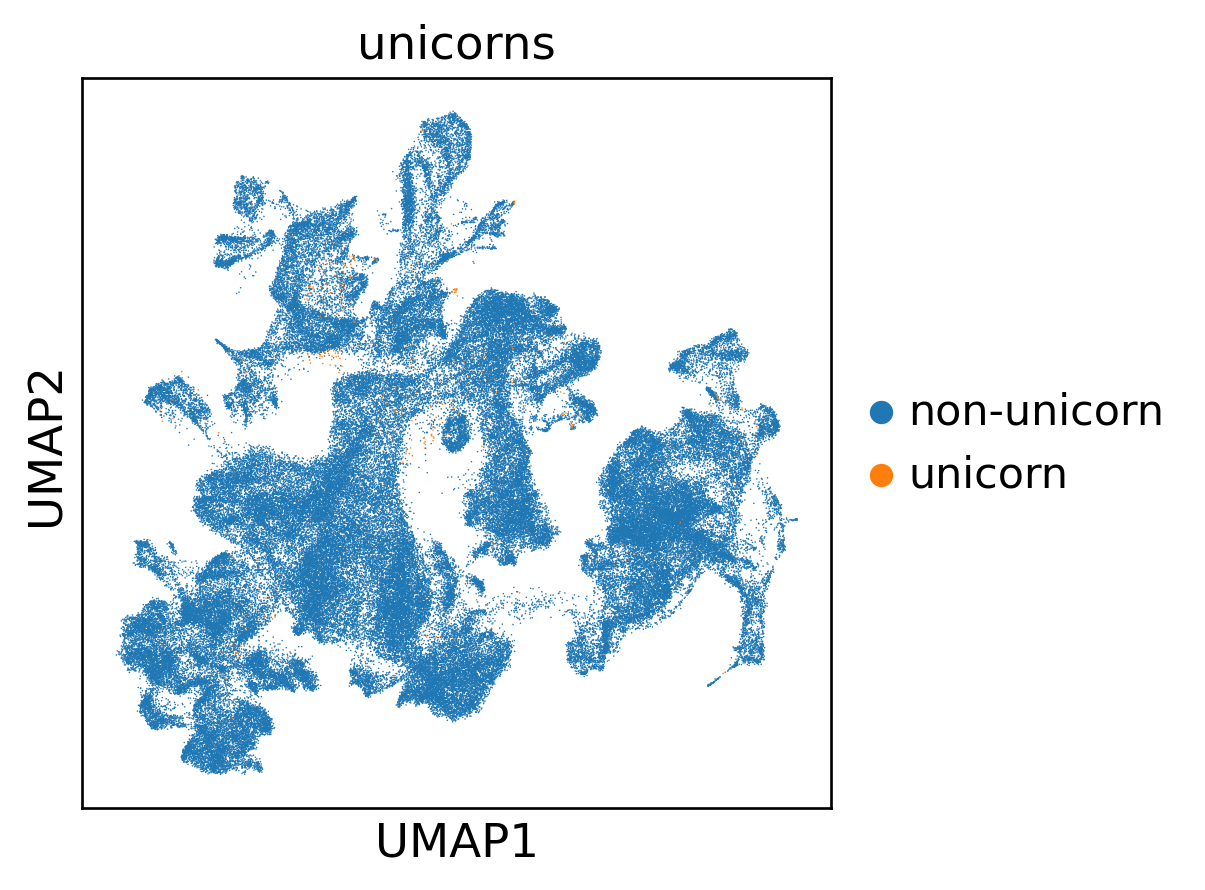

In [17]:
sc.pl.umap(adata, color=['unicorns'])

In [18]:
# subset the AnnData object to remove "unicorns"
adata = adata[adata.obs['unicorns'] == 'non-unicorn'].copy()

In [19]:
adata

AnnData object with n_obs × n_vars = 141977 × 44223
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'stage', 'percent.mt', 'species', 'embryo', 'platform', 'ann_level_2', 'ann_level_3', 'ann_level_1', 'doublet', 'doublet_score', 'Unintegrated_res_0.5', 'Scanorama_res_0.5', 'LIGER_res_0.5', 'Harmony_res_0.5', 'scVI_res_0.5', 'scANVI_res_0.5', 'CCA_res_0.5', 'FastMNN_res_0.5', 'leiden_1', 'leiden_2', 'leiden_3', 'leiden_4', 'reanno', 'lineage', 'unicorns', 'combined_annotation'
    var: 'features', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'CCA_res_0.5_colors', 'FastMNN_res_0.5_colors', 'Harmony_res_0.5_colors', 'LIGER_res_0.5_colors', 'Scanorama_res_0.5_colors', 'Unintegrated_res_0.5_colors', 'anno_colors', 'harmo.anno_colors', 'hvg', 'leiden', 'leiden_3_colors', 'log1p', 'neighbors', 'orig.ident_colors', 'pca', 'scANVI_res_0.5_colors', 'scVI_res_0.5_colors', 'stage_colors'

In [20]:
set(adata.obs.unicorns)

{'non-unicorn'}

In [21]:
#check annotations by stage
df = pd.crosstab(adata.obs['orig.ident'], adata.obs['reanno']).reset_index()
df = df.melt(id_vars='orig.ident', var_name='reanno', value_name='Freq')

# Remove rows where 'Freq' is 0
df = df[df['Freq'] != 0]

# Set display options to show all rows and columns
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns

# Print the DataFrame
print(df)

orig.ident                             reanno  Freq
2     Nakamura                                 TE    53
8           Ma                             CTBs_1    20
9     Nakamura                             CTBs_1    49
10         Niu                             CTBs_1    55
11        Yang                             CTBs_1  1552
14        Gong                             CTBs_2    85
15          Ma                             CTBs_2    64
18        Yang                             CTBs_2  1999
19   Zhai_2022                             CTBs_2    11
21        Gong                             CTBs_3    38
22          Ma                             CTBs_3     5
24         Niu                             CTBs_3     2
25        Yang                             CTBs_3   689
26   Zhai_2022                             CTBs_3   352
27   Zhai_2023                             CTBs_3    19
28        Gong                             STBs_1  3194
29          Ma                             STBs_1   105
31         Niu                             STBs_1    15
32        Yang                             STBs_1   902
33   Zhai_2022                             STBs_1   103
34   Zhai_2023                             STBs_1     8
35        Gong                             STBs_2   194
43          Ma                             STBs_3     4
45         Niu                             STBs_3     3
46        Yang                             STBs_3   407
49        Gong                             STBs_4    52
50          Ma                             STBs_4    15
53        Yang                             STBs_4   787
54   Zhai_2022                             STBs_4    50
55   Zhai_2023                             STBs_4     6
56        Gong                             EVTs_1  1436
57          Ma                             EVTs_1    61
59         Niu                             EVTs_1    16
60        Yang                             EVTs_1  3013
61   Zhai_2022                             EVTs_1   270
62   Zhai_2023                             EVTs_1    27
63        Gong                             EVTs_2   645
64          Ma                             EVTs_2    14
66         Niu                             EVTs_2    17
67        Yang                             EVTs_2   577
68   Zhai_2022                             EVTs_2     5
69   Zhai_2023                             EVTs_2    52
70        Gong                             EVTs_3  4763
73         Niu                             EVTs_3     8
76   Zhai_2023                             EVTs_3     2
77        Gong                             EVTs_4  4640
78          Ma                             EVTs_4    50
79    Nakamura                             EVTs_4     6
80         Niu                             EVTs_4    16
81        Yang                             EVTs_4  1075
82   Zhai_2022                             EVTs_4   952
83   Zhai_2023                             EVTs_4    21
84        Gong                             EVTs_5  1537
93    Nakamura                              Epi_1    29
102       Yang                              Epi_2   628
105       Gong                              Epi_3   326
106         Ma                              Epi_3   198
107   Nakamura                              Epi_3    82
108        Niu                              Epi_3   101
109       Yang                              Epi_3   814
110  Zhai_2022                              Epi_3   794
111  Zhai_2023                              Epi_3     1
112       Gong                              Epi_4   656
113         Ma                              Epi_4   141
114   Nakamura                              Epi_4    29
115        Niu                              Epi_4    13
116       Yang                              Epi_4    33
117  Zhai_2022                              Epi_4  3015
119       Gong                              Epi_5     6
120         Ma                              Epi_5    21
124  Zhai_2022              

In [22]:
# remove cells with conflicting annotations
df_counts = pd.crosstab(adata.obs['reanno'], adata.obs['orig.ident']).reset_index()
df_counts = pd.melt(df_counts, id_vars=['reanno'], var_name='orig.ident', value_name='Freq')

# Filter to find rows where Freq <= 4
low_count_rows = df_counts[df_counts['Freq'] <= 5]

# Combine 'reanno' and 'stage' into a single annotation for filtering
adata.obs['combined_annotation'] = adata.obs['reanno'].astype(str) + "_" + adata.obs['orig.ident'].astype(str)

# Create a list of combined annotations to remove
annotations_to_remove = low_count_rows.apply(lambda row: f"{row['reanno']}_{row['orig.ident']}", axis=1).tolist()

# Identify cells that match the annotations to remove
cells_to_remove = adata.obs['combined_annotation'].isin(annotations_to_remove)

# Add 'unicorn' as a category if it's not already in the categories
if 'unicorn' not in adata.obs['unicorns'].cat.categories:
    adata.obs['unicorns'] = adata.obs['unicorns'].cat.add_categories(['unicorn'])
    
# Update 'unicorns' column: if a cell matches the annotations to remove, set it to 'unicorns'
# Keep existing 'unicorns' labels and only add new ones
adata.obs.loc[cells_to_remove, 'unicorns'] = 'unicorn'

# Optional: You can ensure that cells not in the annotations_to_remove list keep their previous labels
# Uncomment the following line if you want to ensure 'unicorns' label is kept only for relevant cells
# adata.obs.loc[~cells_to_remove, 'unicorns'] = adata.obs.loc[~cells_to_remove, 'unicorns']


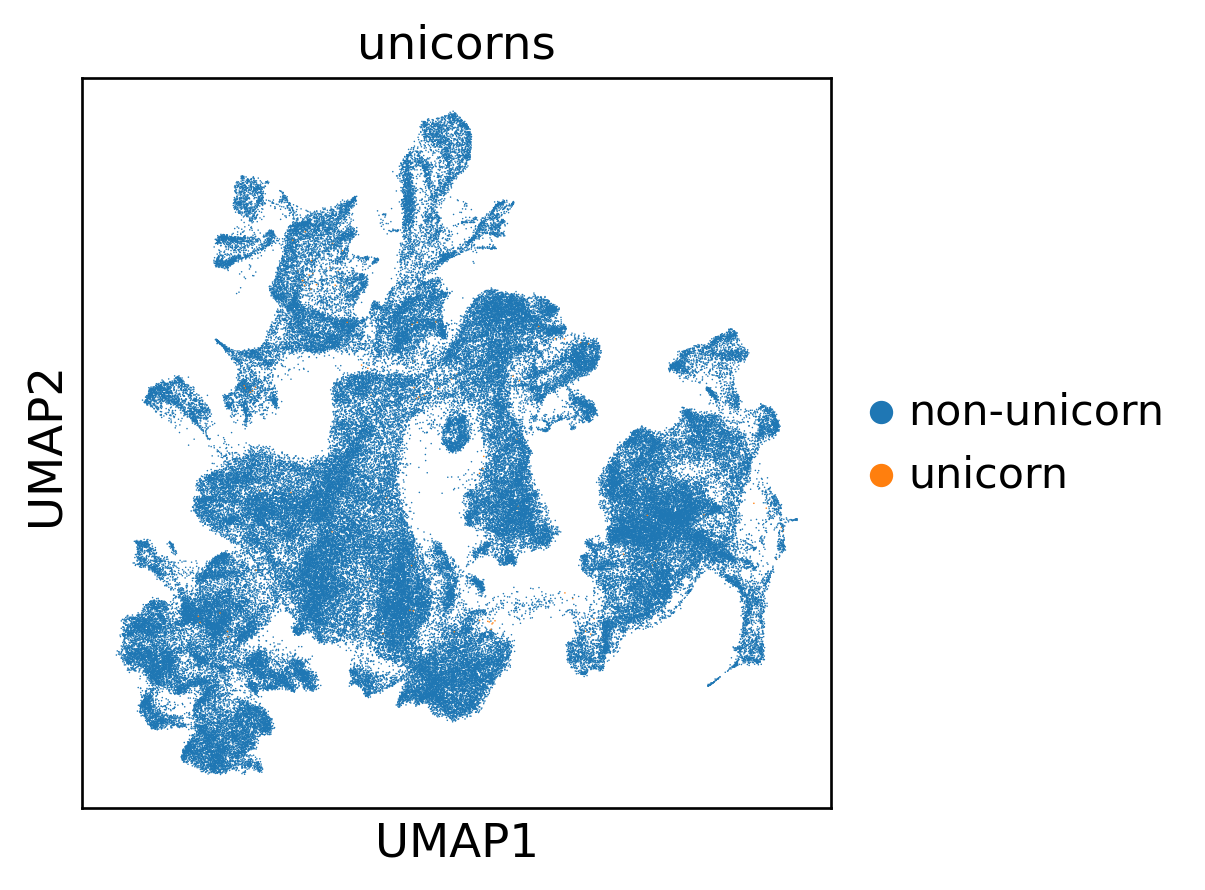

In [23]:
sc.pl.umap(adata, color=['unicorns'])

In [24]:
# subset the AnnData object to remove "unicorns"
adata = adata[adata.obs['unicorns'] == 'non-unicorn'].copy()

In [25]:
adata

AnnData object with n_obs × n_vars = 141868 × 44223
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'stage', 'percent.mt', 'species', 'embryo', 'platform', 'ann_level_2', 'ann_level_3', 'ann_level_1', 'doublet', 'doublet_score', 'Unintegrated_res_0.5', 'Scanorama_res_0.5', 'LIGER_res_0.5', 'Harmony_res_0.5', 'scVI_res_0.5', 'scANVI_res_0.5', 'CCA_res_0.5', 'FastMNN_res_0.5', 'leiden_1', 'leiden_2', 'leiden_3', 'leiden_4', 'reanno', 'lineage', 'unicorns', 'combined_annotation'
    var: 'features', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'CCA_res_0.5_colors', 'FastMNN_res_0.5_colors', 'Harmony_res_0.5_colors', 'LIGER_res_0.5_colors', 'Scanorama_res_0.5_colors', 'Unintegrated_res_0.5_colors', 'anno_colors', 'harmo.anno_colors', 'hvg', 'leiden', 'leiden_3_colors', 'log1p', 'neighbors', 'orig.ident_colors', 'pca', 'scANVI_res_0.5_colors', 'scVI_res_0.5_colors', 'stage_colors'

In [26]:
#check annotations by stage
df = pd.crosstab(adata.obs['orig.ident'], adata.obs['reanno']).reset_index()
df = df.melt(id_vars='orig.ident', var_name='reanno', value_name='Freq')

# Remove rows where 'Freq' is 0
df = df[df['Freq'] != 0]

# Set display options to show all rows and columns
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns

# Print the DataFrame
print(df)

orig.ident                             reanno  Freq
2     Nakamura                                 TE    53
8           Ma                             CTBs_1    20
9     Nakamura                             CTBs_1    49
10         Niu                             CTBs_1    55
11        Yang                             CTBs_1  1552
14        Gong                             CTBs_2    85
15          Ma                             CTBs_2    64
18        Yang                             CTBs_2  1999
19   Zhai_2022                             CTBs_2    11
21        Gong                             CTBs_3    38
25        Yang                             CTBs_3   689
26   Zhai_2022                             CTBs_3   352
27   Zhai_2023                             CTBs_3    19
28        Gong                             STBs_1  3194
29          Ma                             STBs_1   105
31         Niu                             STBs_1    15
32        Yang                             STBs_1   902
33   Zhai_2022                             STBs_1   103
34   Zhai_2023                             STBs_1     8
35        Gong                             STBs_2   194
46        Yang                             STBs_3   407
49        Gong                             STBs_4    52
50          Ma                             STBs_4    15
53        Yang                             STBs_4   787
54   Zhai_2022                             STBs_4    50
55   Zhai_2023                             STBs_4     6
56        Gong                             EVTs_1  1436
57          Ma                             EVTs_1    61
59         Niu                             EVTs_1    16
60        Yang                             EVTs_1  3013
61   Zhai_2022                             EVTs_1   270
62   Zhai_2023                             EVTs_1    27
63        Gong                             EVTs_2   645
64          Ma                             EVTs_2    14
66         Niu                             EVTs_2    17
67        Yang                             EVTs_2   577
69   Zhai_2023                             EVTs_2    52
70        Gong                             EVTs_3  4763
73         Niu                             EVTs_3     8
77        Gong                             EVTs_4  4640
78          Ma                             EVTs_4    50
79    Nakamura                             EVTs_4     6
80         Niu                             EVTs_4    16
81        Yang                             EVTs_4  1075
82   Zhai_2022                             EVTs_4   952
83   Zhai_2023                             EVTs_4    21
84        Gong                             EVTs_5  1537
93    Nakamura                              Epi_1    29
102       Yang                              Epi_2   628
105       Gong                              Epi_3   326
106         Ma                              Epi_3   198
107   Nakamura                              Epi_3    82
108        Niu                              Epi_3   101
109       Yang                              Epi_3   814
110  Zhai_2022                              Epi_3   794
112       Gong                              Epi_4   656
113         Ma                              Epi_4   141
114   Nakamura                              Epi_4    29
115        Niu                              Epi_4    13
116       Yang                              Epi_4    33
117  Zhai_2022                              Epi_4  3015
119       Gong                              Epi_5     6
120         Ma                              Epi_5    21
124  Zhai_2022                              Epi_5    39
126       Gong                       Amniotic_epi   644
127         Ma                       Amniotic_epi    47
129        Niu                       Amniotic_epi    10
130       Yang                       Amniotic_epi   517
131  Zhai_2022                       Amniotic_epi  1244
133       Gong                           Amnion_1  1321
134         Ma              

In [ ]:
# Create a larger figure with a custom size
fig, ax = plt.subplots(figsize=(12, 5)) 
sc.pl.violin(
    adata,
    ["doublet_score"],
   groupby="reanno", jitter=0.4,
    multi_panel=True,rotation=90, ax=ax  # Pass the custom ax object to control the plot size
)

fig, ax = plt.subplots(figsize=(12, 5)) 
sc.pl.violin(
    adata,
    [ "doublet"],
   groupby="reanno", jitter=0.4,
    multi_panel=True,rotation=90,ax=ax )

fig, ax = plt.subplots(figsize=(12, 5)) 
sc.pl.violin(
    adata,
    ["nFeature_RNA"],
   groupby="reanno", jitter=0.4,
    multi_panel=True,rotation=90,ax=ax )

fig, ax = plt.subplots(figsize=(12, 5)) 
sc.pl.violin(
    adata,
    [ "percent.mt"],
   groupby="reanno", jitter=0.4,
    multi_panel=True,rotation=90,ax=ax )

In [28]:
##save dataset
adata.raw.var.rename(columns={'_index': 'index'}, inplace=True)
adata.write_h5ad(filename="monkey_reanno_clean.h5ad")

In [29]:
#dot plot
meso_marker_genes = {
    "Primitive.streak": ["TBXT", "SP5", "HOXA1", "CDX1", "CDX2","MIXL1", "FST" ],
    "meso.general":["PDGFRA", "MESP1",  "GATA6",],
    "emergent.meso": ["LEFTY2", "OTX2","LHX1" ],
    "Nascent.meso":["TBX6","MEIS1",],
    "Notochord":["CHRD", "NOTO"],
    "Axial.meso": ["DCLK1", "ESRG",],
    "Paraxial.meso":["MSGN1", "HES7", ],
    "Caudal.meso":[ "SFRP2", "HOXA1"],
    "Rostral.meso":[ "PITX2", "IRX3"],
    "Intermediate.meso":["PAX8", "OSR1", "EYA1", ],
    "lateral plate.meso":["HAND1", "MYL7","HAPLN1", "BMP4", "FOXF1", "SNAI2" ],
    "ExE mesoderm progenitor":["LUM", "POSTN", "IGF2", "ANXA1"],
   "YS mesoderm":[ "CREB3L1", "NR2F2", "PLAGL1", "ANXA1", "NID2"],
    #"Allantoic stalk":["CDX1", "CDX2", "FGF9", "FGF18", "SHH", "WNT5B", "MDK"],

   # "myocyte": ["PITX2", "TGFBI"],
    "cardio myocyte":["TNNT2", "MYL7", "TNNI1", "MYH10"],
    "somite":["ALDH1A2",  "MEOX2", "MEOX1",  "FOXC2"],

     "ecto.epi.general":[ "POU5F1", "DNMT3B","EPCAM","CLDN6"],
    #"radial glial":["CDH2", "NES",  "FABP7", "VIM"],
     "neural.ecto":["SOX3", "PAX6", "TTYH1"],
     "neural crest":["SOX10", "MPZ", "TFAP2A"],
     "neural tube":["SOX2", "OTX2", "RFX4"],
    "proliferating.meso": ["MKI67", "TOP2A", "CDK1" ],
    #"Amniotic.ecto": ["TFAP2C", "GATA3", "MSX2",  "WNT6","DLX5",],
        "EXM": ["DEPDC1B", "FBN2", "FRMD4B", "HAND2", "OAF"],
    "Allantois": ["COL6A2", "COL6A1",  "PCOLCE", "VCAN"],
   
}

In [30]:
# Use value_counts to count the number of cells in each cluster
cluster_counts = adata.obs['leiden_3'].value_counts()

# Set the display option to show all rows
pd.set_option('display.max_rows', None)

# Print the counts
print(cluster_counts)


0.0.0      9486
0.0.1      9061
0.0.2      7149
0.0.3      6317
0.2.0      5549
0.3.0      5147
1.0.0      4313
0.5.0      4022
0.4.0      3827
0.6.0      3626
0.3.1      3164
0.4.1      2880
1.1.0      2648
1.3.0      2576
0.7.0      2519
0.1.2      2462
0.5.1      2368
0.7.1      2328
0.1.4      2315
1.2.0      2292
1.3.1      2195
1.0.1      2159
0.1.0.0    2142
0.8.0      1919
1.2.1      1794
0.1.0.1    1745
0.3.2      1722
0.2.1      1714
0.6.1      1679
0.6.2      1587
0.2.2      1562
1.1.1      1435
0.3.3      1369
1.0.2      1340
1.1.2      1305
0.1.0.2    1185
0.7.2      1180
1.0.3      1107
0.1.3.0    1083
0.6.3      1072
0.8.1      1069
1.4.0      1023
0.1.1.0     928
1.2.2       910
1.5.0       897
0.4.4       877
0.2.3       862
0.8.2       841
0.7.3       827
0.1.1.1     809
0.6.4       801
0.10.0      795
0.3.4       757
1.1.3       740
0.5.3       729
0.9.0       729
1.4.1       653
0.1.1.2     648
1.5.1       640
0.12.0      628
0.0.4       590
0.11.0      589
0.1.3.1     561
0.1.3.2     538
0.2.5       449
0.11.1      445
0.10.1      423
0.1.1.3     419
1.6.0       418
0.9.1       416
0.9.2       411
1.4.2       407
0.1.3.3     345
0.4.2.0     336
0.4.5       328
0.3.5       320
1.6.1       296
0.10.2      272
0.2.4       265
0.4.2.1     253
0.4.3       250
1.5.2       241
0.9.3       240
0.4.2.2     230
1.6.2       204
1.7.0       194
1.6.3       180
0.12.1      163
0.6.5       156
0.4.2.3      72
0.1.0.3      66
0.4.2.4      62
0.8.3        60
1.4.3        53
0.1.3.4      48
0.12.2       29
0.9.4        24
0.3.6         9
Name: leiden_3, dtype: int64

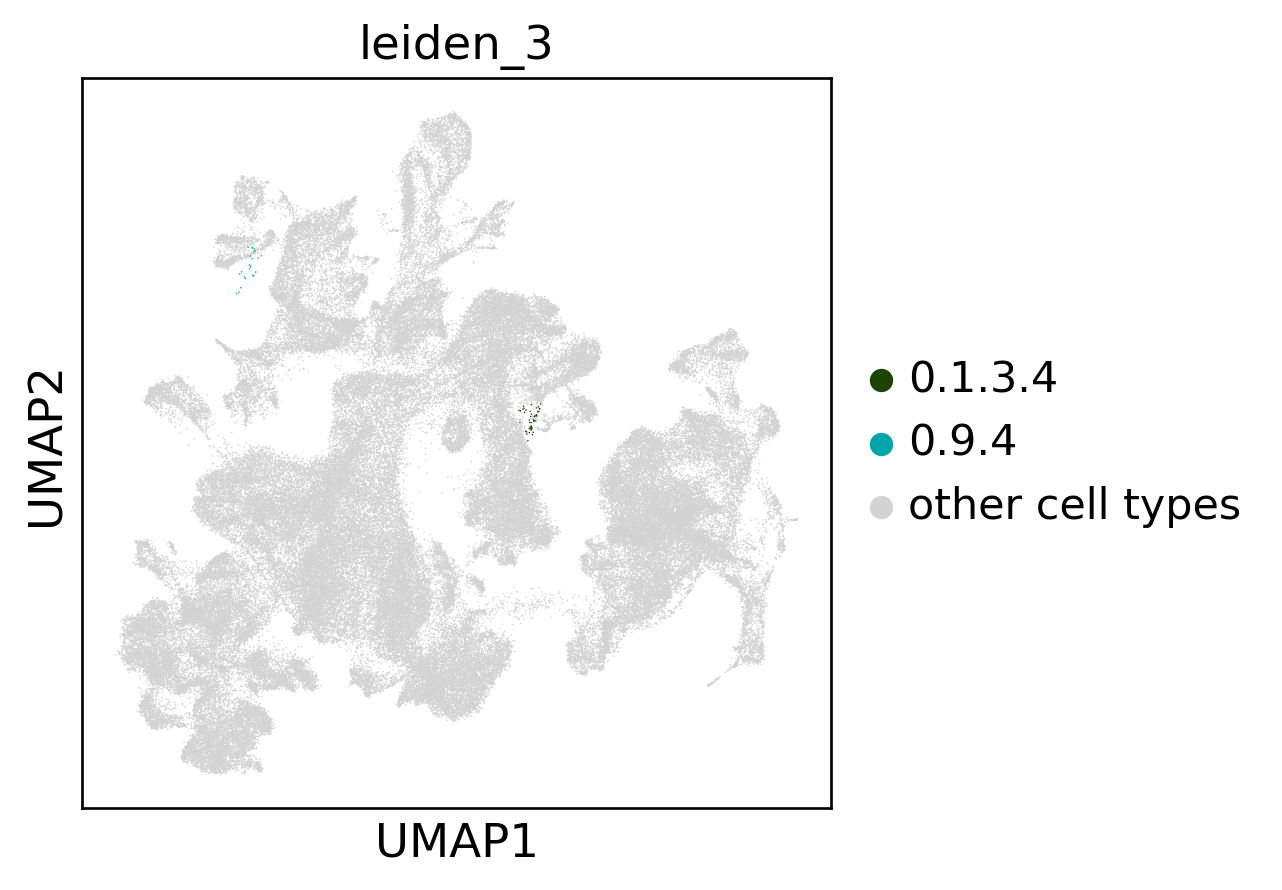

In [31]:
# Plot UMAP with specified colors and groups
ax = sc.pl.umap(adata, color=["leiden_3"], groups=[ '0.1.3.4', '0.9.4', ], show=False)

# Change legend text from "NA" to "other cell types"
legend_texts = ax.get_legend().get_texts()
for legend_text in legend_texts:
    if legend_text.get_text() == "NA":
       legend_text.set_text("other cell types")

In [32]:
adata

AnnData object with n_obs × n_vars = 141868 × 44223
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'sample', 'stage', 'percent.mt', 'species', 'embryo', 'platform', 'ann_level_2', 'ann_level_3', 'ann_level_1', 'doublet', 'doublet_score', 'Unintegrated_res_0.5', 'Scanorama_res_0.5', 'LIGER_res_0.5', 'Harmony_res_0.5', 'scVI_res_0.5', 'scANVI_res_0.5', 'CCA_res_0.5', 'FastMNN_res_0.5', 'leiden_1', 'leiden_2', 'leiden_3', 'leiden_4', 'reanno', 'lineage', 'unicorns', 'combined_annotation'
    var: 'features', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'CCA_res_0.5_colors', 'FastMNN_res_0.5_colors', 'Harmony_res_0.5_colors', 'LIGER_res_0.5_colors', 'Scanorama_res_0.5_colors', 'Unintegrated_res_0.5_colors', 'anno_colors', 'harmo.anno_colors', 'hvg', 'leiden', 'leiden_3_colors', 'log1p', 'neighbors', 'orig.ident_colors', 'pca', 'scANVI_res_0.5_colors', 'scVI_res_0.5_colors', 'stage_colors'

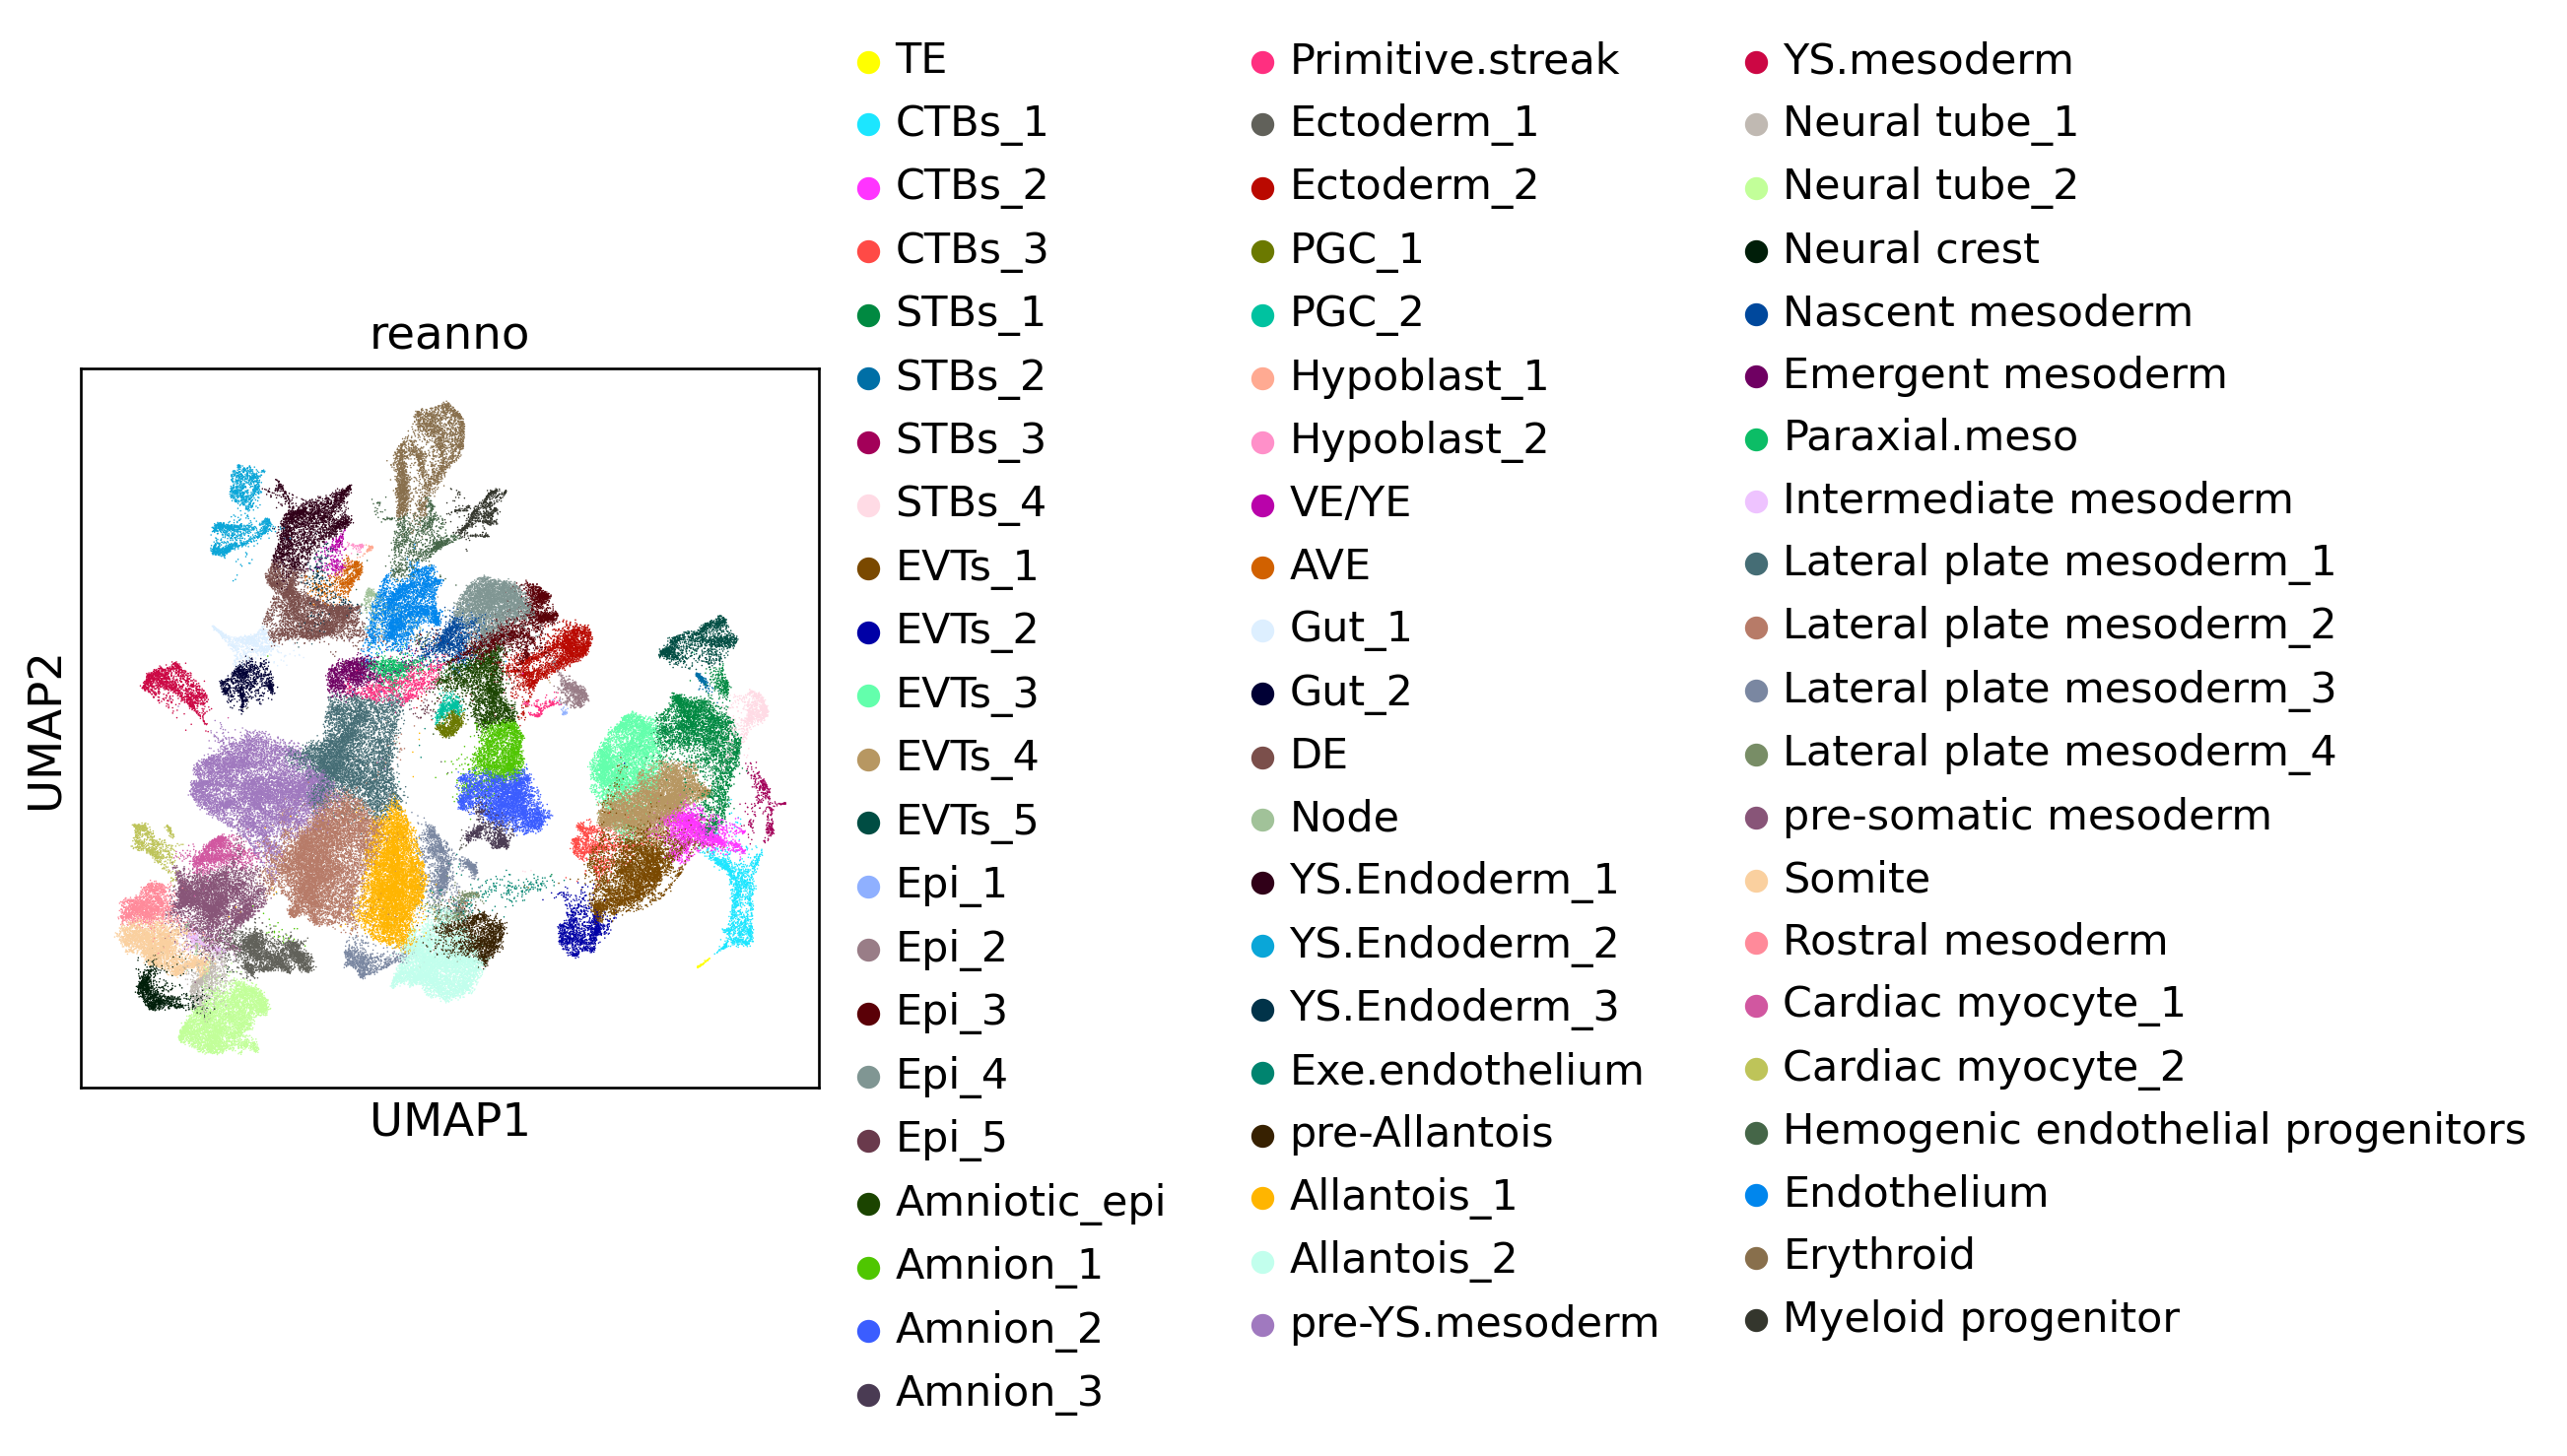

In [33]:
sc.pl.umap(adata, color=['reanno'])

In [34]:
# Use value_counts to count the number of cells in each cluster
cluster_counts = adata.obs['reanno'].value_counts()

# Set the display option to show all rows
pd.set_option('display.max_rows', None)

# Print the counts
print(cluster_counts)


Lateral plate mesoderm_2             9486
pre-YS.mesoderm                      9061
Allantois_1                          7149
Lateral plate mesoderm_1             6907
EVTs_4                               6760
Allantois_2                          5549
pre-somatic mesoderm                 5147
Neural tube_2                        4847
EVTs_1                               4823
EVTs_3                               4771
STBs_1                               4327
Amnion_2                             4022
Epi_4                                3887
DE                                   3827
Endothelium                          3626
Erythroid                            3266
Somite                               3164
YS.Endoderm_1                        2880
Ectoderm_1                           2760
Ectoderm_2                           2575
Amniotic_epi                         2462
Lateral plate mesoderm_3             2424
Amnion_1                             2368
Epi_3                                2315
CTBs_2                               2159
YS.Endoderm_2                        1820
Rostral mesoderm                     1722
pre-Allantois                        1714
CTBs_1                               1676
EVTs_5                               1537
YS.mesoderm                          1490
Cardiac myocyte_1                    1378
Emergent mesoderm                    1347
EVTs_2                               1305
Hemogenic endothelial progenitors    1228
Nascent mesoderm                     1185
Neural crest                         1180
CTBs_3                               1098
Gut_2                                1069
Primitive.streak                      972
STBs_4                                910
Gut_1                                 877
Neural tube_1                         827
Myeloid progenitor                    801
Cardiac myocyte_2                     757
Amnion_3                              729
Paraxial.meso                         648
Epi_2                                 628
PGC_1                                 589
AVE                                   566
Lateral plate mesoderm_4              449
PGC_2                                 445
STBs_3                                407
Node                                  388
Intermediate mesoderm                 320
Exe.endothelium                       265
VE/YE                                 253
YS.Endoderm_3                         250
STBs_2                                194
Hypoblast_1                            72
Epi_5                                  66
Hypoblast_2                            62
TE                                     53
Epi_1                                  29
Name: reanno, dtype: int64

In [ ]:
FIGURES = dict()
fz = 12
annos = ['ann_level_2','ann_level_3','stage', 'orig.ident']
for x in annos:
    study_count_per_ct = pd.crosstab(adata.obs['reanno'], adata.obs[x])
    study_perc_per_ct = (
        study_count_per_ct.divide(study_count_per_ct.sum(axis=1), axis=0) * 100
    )

    with plt.rc_context(
        {
            "figure.figsize": (14, 3),
            "xtick.labelsize": fz,
            "ytick.labelsize": fz,
            "axes.labelsize": fz,
            "font.size": fz,
            "axes.spines.right": False,
            "axes.spines.top": False,
        }
    ):
        fig, ax = plt.subplots()
        study_perc_per_ct.plot(kind="bar", stacked=True, ax=ax, cmap="tab20", grid=False)
        handles, labels = ax.get_legend_handles_labels()
        labels = [lab.capitalize() for lab in labels]
        ax.legend(
            handles[::-1],
            labels[::-1],
            loc=(1.01, -0.3),
            fontsize=fz,
            frameon=False,
            title=f"{x.capitalize()}:",
        )
        leg = ax.get_legend()
        leg._legend_box.align = "left"
        plt.ylabel("% of cells")
        plt.xlabel("Annotation")
        FIGURES[f"ED_4a_cell_type_{x}"] = fig
        plt.show()

In [ ]:
# Generate and save the UMAP plot
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
sc.pl.umap(adata, color=['reanno'], save='monkey_reanno.pdf')  # Save as PDF file

In [ ]:
# Define your color panel
color_panel = {
    'TE_TrB': "#E377C2",
    'epi': "#B5BD61",
    'Gastru': "#D62728",
    'Notochord': "#AA40FC",
    'PGC': "#8C564B",
    'ExE_endo': "#FF7F0E",
    'Exe_meso': "#279E68",
    'non_neuro_ecto': "#98DF8A",
    'neural_ecto': "#FFBB78",
    'Endoderm': "#1F77B4", 
    'mesoderm': "#AEC7E8",
    'hemogenic': "#17BECF"
}

# Apply the color panel to the lineage categories
sc.pl.umap(adata, color=['lineage'], palette=[color_panel.get(x, "#333333") for x in adata.obs['lineage'].cat.categories], save='monkey_lineage.pdf')

In [ ]:
sc.pl.umap(adata, color=['stage'], save='monkey_stage.pdf')

In [ ]:
FIGURES = dict()
fz = 12
annos = ['ann_level_1', 'ann_level_2','ann_level_3','orig.ident', 'stage']
for x in annos:
    study_count_per_ct = pd.crosstab(adata.obs['reanno'], adata.obs[x])
    study_perc_per_ct = (
        study_count_per_ct.divide(study_count_per_ct.sum(axis=1), axis=0) * 100
    )

    with plt.rc_context(
        {
            "figure.figsize": (14, 3),
            "xtick.labelsize": fz,
            "ytick.labelsize": fz,
            "axes.labelsize": fz,
            "font.size": fz,
            "axes.spines.right": False,
            "axes.spines.top": False,
        }
    ):
        fig, ax = plt.subplots()
        study_perc_per_ct.plot(kind="bar", stacked=True, ax=ax, cmap="tab20", grid=False)
        handles, labels = ax.get_legend_handles_labels()
        labels = [lab.capitalize() for lab in labels]
        ax.legend(
            handles[::-1],
            labels[::-1],
            loc=(1.01, -0.3),
            fontsize=fz,
            frameon=False,
            title=f"{x.capitalize()}:",
        )
        leg = ax.get_legend()
        leg._legend_box.align = "left"
        plt.ylabel("% of cells")
        plt.xlabel("Annotation")
        FIGURES[f"ED_4a_cell_type_{x}"] = fig
        plt.show()

In [ ]:
FIGURES = dict()
fz = 12
annos = [ 'reanno','lineage']
for x in annos:
    study_count_per_ct = pd.crosstab(adata.obs['stage'], adata.obs[x])
    study_perc_per_ct = (
        study_count_per_ct.divide(study_count_per_ct.sum(axis=1), axis=0) * 100
    )

    with plt.rc_context(
        {
            "figure.figsize": (14, 3),
            "xtick.labelsize": fz,
            "ytick.labelsize": fz,
            "axes.labelsize": fz,
            "font.size": fz,
            "axes.spines.right": False,
            "axes.spines.top": False,
        }
    ):
        fig, ax = plt.subplots()
        study_perc_per_ct.plot(kind="bar", stacked=True, ax=ax, cmap="tab20", grid=False)
        handles, labels = ax.get_legend_handles_labels()
        labels = [lab.capitalize() for lab in labels]
        ax.legend(
            handles[::-1],
            labels[::-1],
            loc=(1.01, -0.3),
            fontsize=fz,
            frameon=False,
            title=f"{x.capitalize()}:",
        )
        leg = ax.get_legend()
        leg._legend_box.align = "left"
        plt.ylabel("% of cells")
        plt.xlabel("Annotation")
        FIGURES[f"ED_4a_cell_type_{x}"] = fig
        plt.show()

In [41]:
# Obtain cluster-specific differentially expressed genes
sc.tl.rank_genes_groups(adata, groupby="reanno", method="wilcoxon",use_raw=False)
sc.tl.dendrogram(adata, groupby="reanno")
#sc.pl.rank_genes_groups_dotplot(adata, groupby="reanno", standard_scale="var", n_genes=5,use_raw=False, save='monkey_marker.pdf')

In [ ]:
# Set constrained layout when creating the figure
fig, axs = plt.subplots(figsize=(60, 20), dpi=100, constrained_layout=True)  # Adjust the size and DPI as needed

# Perform the dotplot (assuming 'adata' and 'reanno' are defined in your data)
sc.pl.rank_genes_groups_dotplot(adata, groupby="reanno", standard_scale="var", n_genes=5, use_raw=False, ax=axs)

# Save the figure, ensuring that the size doesn't exceed limits
try:
    fig.savefig('dotplot_monkey_marker.pdf', dpi=100, bbox_inches='tight')
except ValueError as e:
    print(f"Error: {e}")
    plt.close(fig)
else:
    plt.show()